In [1]:
#calibrate the camera
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline


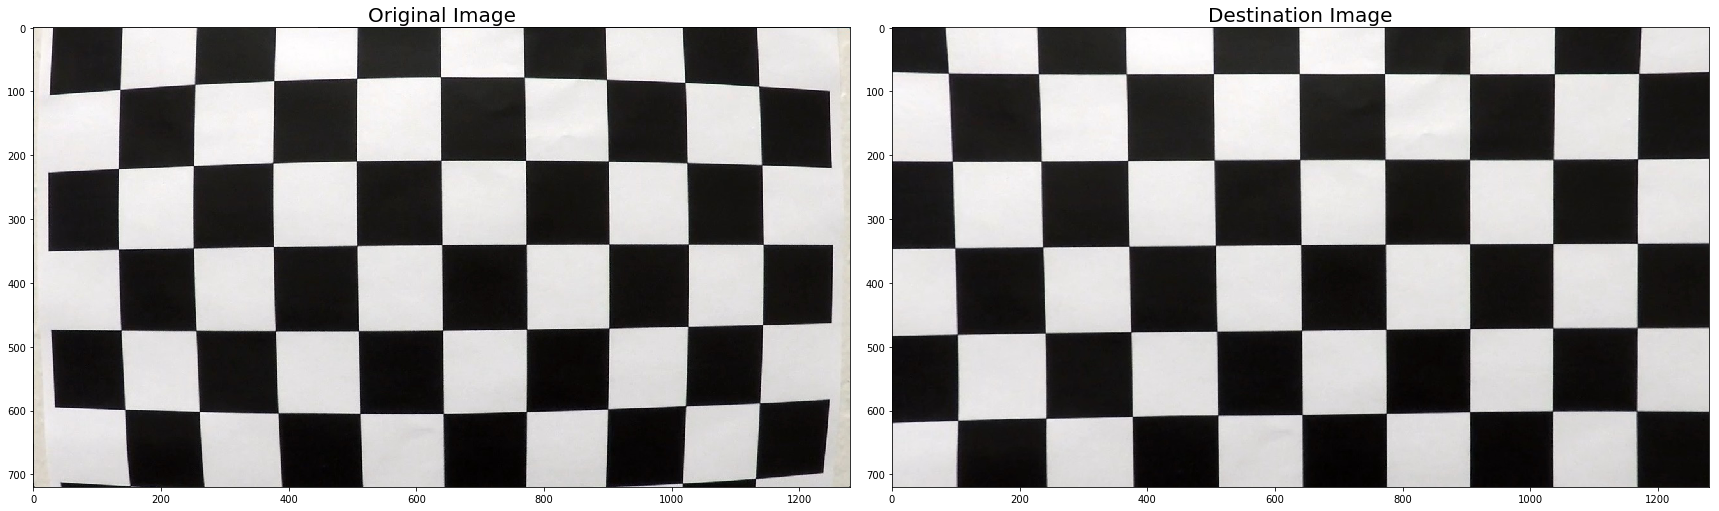

In [2]:
def calibrate_camera(image_filenames, nx, ny):
    # Arrays to store object and image points from all the images
    objpoints = [] # 3d points in real world
    imgpoints = [] # 2d points in image
    
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    for fname in image_filenames:

        # Read calibration image
        img = mpimg.imread(fname)

        # convert img to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found, then add the object and image points to the corresponding arrays
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #plt.imshow(img)    
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


image_filenames = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(glob.glob('camera_cal/calibration*.jpg'), nx=9, ny=6)

test_img = mpimg.imread('camera_cal/calibration1.jpg')

dst = cv2.undistort(test_img, mtx, dist, None, mtx)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Destination Image', fontsize=20)

mpimg.imsave('output_images/calibrated_image1.jpg', dst)


In [3]:
# Define the Gradient and thresholds

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_threshold(image, channel = 's', thresh=(50,100)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    if channel == 's' :
        channel_img = S
    
    if channel == 'h':
        channel_img = H
    
    binary = np.zeros_like(channel_img)
    binary[(channel_img> thresh[0]) & (channel_img < thresh[1])] = 1
    
    return binary

Text(0.5,1,'H Image.')

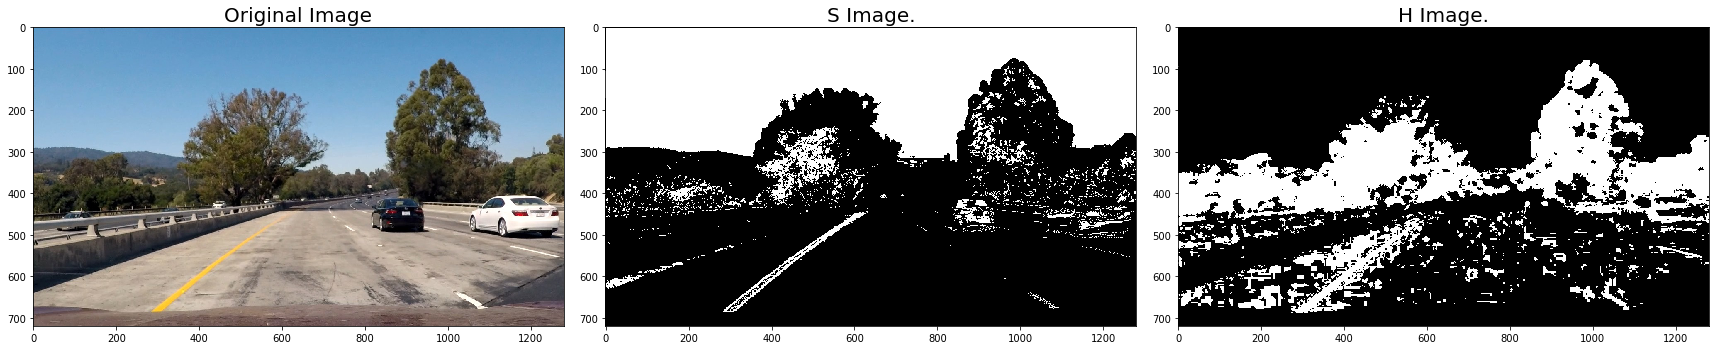

In [4]:
s_threshold = (90,255)
h_threshold = (15,100)
#image_file_name = './test_images/straight_lines1.jpg'
image_file_name = './test_images/test1.jpg'
image = mpimg.imread(image_file_name)
s_image = hls_threshold(image, channel = 's', thresh=s_threshold)
h_image = hls_threshold(image, channel = 'h', thresh=h_threshold)


mpimg.imsave('output_images/test1_s_image.jpg', s_image)
mpimg.imsave('output_images/test1_h_image.jpg', h_image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(s_image, cmap='gray')
ax2.set_title('S Image.', fontsize=20)
ax3.imshow(h_image, cmap='gray')
ax3.set_title('H Image.', fontsize=20)

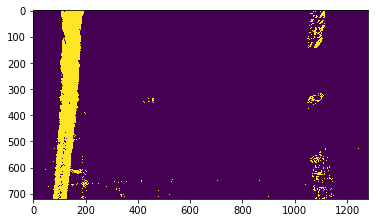

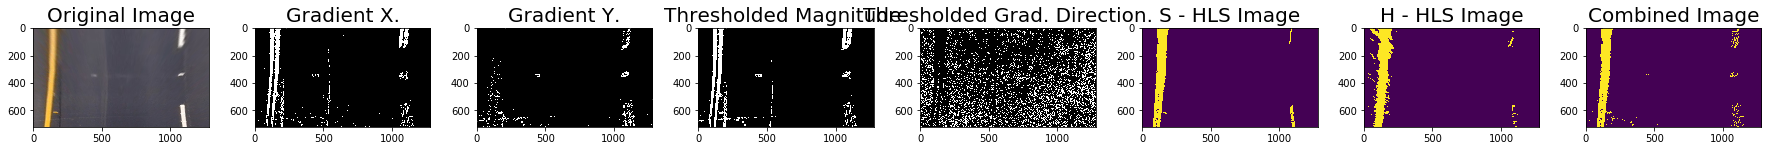

In [5]:

def apply_gradient_and_thresholds(image, kernel_size = 9):
    # Choose a Sobel kernel size
    kernel_size = 9 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh=(10, 90))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=kernel_size, thresh=(10, 90))
    mag_binary = mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(10, 90))
    dir_binary = dir_threshold(image, sobel_kernel=kernel_size, thresh=(0.8, 1.2))
    saturation_binary = hls_threshold(image, channel = 's', thresh=(90,255))
    hue_binary = hls_threshold(image, channel = 'h', thresh=(15, 100))

    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((saturation_binary == 1) & (hue_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((saturation_binary == 1) & (hue_binary == 1))] = 1
    
    return combined, gradx, grady, mag_binary, dir_binary, saturation_binary, hue_binary


#image_file_name = './test_images/straight_lines2.jpg'
#image_file_name = './test_images/test4.jpg'
image_file_name = './output_images/warped_lane_image.jpg'
image = mpimg.imread(image_file_name)

image = cv2.undistort(image, mtx, dist, None, mtx)

combined, gradx, grady, mag_binary, dir_binary, saturation_binary, hue_binary = apply_gradient_and_thresholds(image, kernel_size = 9)

# write each of the above images to output folder
mpimg.imsave('output_images/warped_lane_image_gradx.jpg', gradx)
mpimg.imsave('output_images/warped_lane_image_grady.jpg', grady)
mpimg.imsave('output_images/warped_lane_image_mag_binary.jpg', mag_binary)
mpimg.imsave('output_images/warped_lane_image_dir_binary.jpg', dir_binary)
mpimg.imsave('output_images/warped_lane_image_saturation_binary.jpg', saturation_binary)
mpimg.imsave('output_images/warped_lane_image_hue_binary.jpg', hue_binary)
mpimg.imsave('output_images/warped_lane_image_combined.jpg', combined)


#plt.imshow(gradx)
#plt.imshow(saturation_binary)
plt.imshow(combined)


# Plot the result
f, (ax1, ax2, ax3,ax4,ax5,ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Gradient X.', fontsize=20)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Gradient Y.', fontsize=20)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Thresholded Magnitude.', fontsize=20)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Grad. Direction.', fontsize=20)
ax6.imshow(saturation_binary)
ax6.set_title('S - HLS Image', fontsize=20)
ax7.imshow(hue_binary)
ax7.set_title('H - HLS Image', fontsize=20)
ax8.imshow(combined)
ax8.set_title('Combined Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

warped shape  (720, 1280, 3)


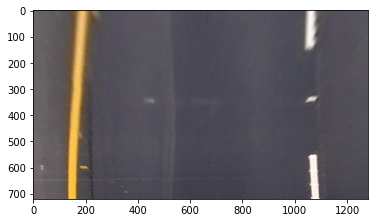

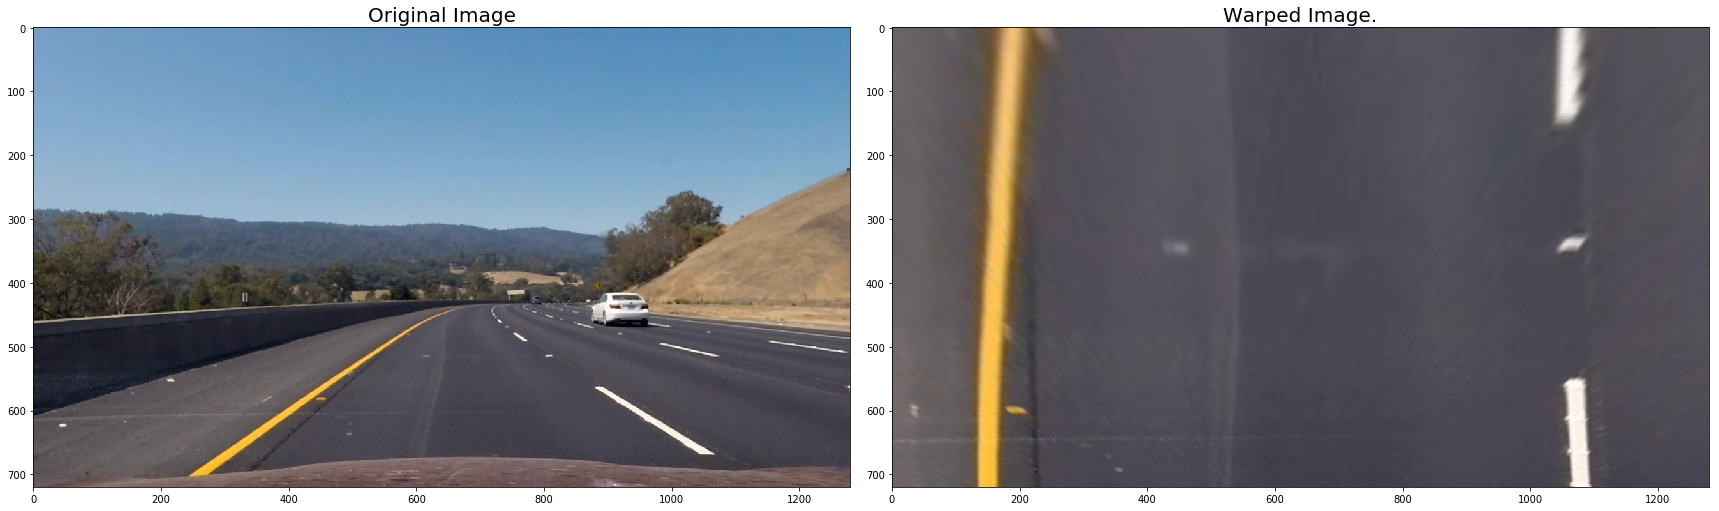

In [6]:

def warp_image(image):
    img_size = image.shape

    source = np.float32([[200,660],[1200,660],[800,480],[540,480]])
    #destination = np.float32([[530,576],[530,400],[820,400],[820,576]])
    destination = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                      [img_size[1],0],[0,0]])

    M = cv2.getPerspectiveTransform(source, destination)
    Minv = cv2.getPerspectiveTransform(destination, source)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return warped, M, Minv


# Perspective Transform
#image_file_name = './test_images/straight_lines1.jpg'
image_file_name = './test_images/test3.jpg'
image = mpimg.imread(image_file_name)

image = cv2.undistort(image, mtx, dist, None, mtx)

warped, M, Minv = warp_image(image)

print('warped shape ', warped.shape)
plt.imshow(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image.', fontsize=20)

mpimg.imsave('output_images/warped_lane_image.jpg', warped)

True

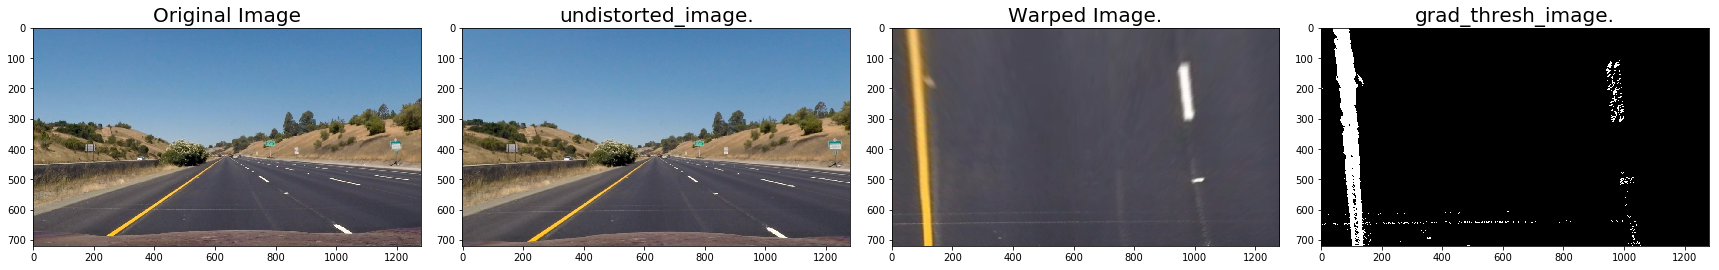

In [7]:
# Pipeline Trial

def pipeline_trial(image):
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(glob.glob('camera_cal/calibration*.jpg'), nx=9, ny=6)
    
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    warped_image, M, Minv = warp_image(undistorted_image)
    
    grad_thresh_image, gradx, grady, mag_binary, dir_binary, saturation_binary, hue_binary = apply_gradient_and_thresholds(warped_image, kernel_size = 9)
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted_image, cmap='gray')
    ax2.set_title('undistorted_image.', fontsize=20)
    ax3.imshow(warped_image, cmap='gray')
    ax3.set_title('Warped Image.', fontsize=20)
    ax4.imshow(grad_thresh_image, cmap='gray')
    ax4.set_title('grad_thresh_image.', fontsize=20)
    
    return grad_thresh_image

image_file_name = './test_images/straight_lines1.jpg'
#image_file_name = './test_images/test3.jpg'    
image = pipeline_trial(mpimg.imread(image_file_name))
mpimg.imsave('./output_images/grad_thresh_image.jpg', image)
cv2.imwrite('./output_images/grad_thresh_image_cv2.jpg', image)


    

In [8]:
def get_radius_of_curvature(ploty, left_fitx, right_fitx):
    # Find radius of curvature scaling from pixels to meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #print shape to test compatibility
    print('ploty ', ploty.shape)
    #print('lefty ', lefty.shape)
    #print('leftx ', leftx.shape)
    #print('righty ', righty.shape)
    #print('rightx ', rightx.shape)
    print('left_fitx ', left_fitx.shape)
    print('right_fitx ', right_fitx.shape)
    print('np.max(ploty) ', np.max(ploty))
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [9]:
def sliding_window_search(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    print('histogram.shape ', histogram.shape)
    #print('histogram.shape[0] ', histogram.shape[0])
    #print('histogram.shape[1] ', histogram.shape[1])
    #print('histogram.shape[0]//2 ', histogram.shape[0]//2)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    print('midpoint ', midpoint, ', leftx_base ', leftx_base, ', rightx_base ', rightx_base )
    print('binary_warped.shape ', binary_warped.shape)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        print('window count is ', window)
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Find radius of curvature
    left_curverad, right_curverad = get_radius_of_curvature(ploty, left_fitx, right_fitx)
 
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, ploty, left_curverad, right_curverad
    

def visualize_sliding_window_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img):
    # Visualize
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    
#binary_warped = cv2.imread('./output_images/grad_thresh_image_cv2.jpg')

#sliding_window_search(binary_warped)
#left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, ploty, left_curverad, right_curverad = sliding_window_search(binary_warped)

#visualize_sliding_window_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img)
    

In [10]:
def find_lanes_without_sliding_window_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad = get_radius_of_curvature(ploty, left_fitx, right_fitx)
    
    return binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, left_curverad, right_curverad

def visualize_lanes(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, margin=100):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    mpimg.imsave('./output_images/visualized_lane.jpg', result)
    
    
def highlight_lane(warped, left_fitx, right_fitx, ploty, Minv, undist, image_shape):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    return result
    
#binary_warped = mpimg.imread('./output_images/grad_thresh_image_cv2.jpg')
#binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, left_curverad, right_curverad = find_lanes_without_sliding_window_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
#visualize_lanes(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds)

#lane_highlighted_image = highlight_lane(binary_warped, left_fitx, right_fitx, ploty, Minv, undist, image_shape)


In [11]:
def get_lane_center_info(left_fitx, right_fitx, image):
    #print(left_fitx)
    center_of_car = right_fitx[-1] - left_fitx[-1]
    center_of_image = image.shape[1]/2
    #print('center of the car is ', center_of_car)
    #print('center of the image is ', center_of_image)

    xm_per_pix = 3.7/700
    length_from_center = "{0:.2f}".format((abs(center_of_car - center_of_image)*xm_per_pix))
    
    if center_of_car > center_of_image:
        lane_center_info = 'Car is ' + str(length_from_center) + '(m) to the left of the lane center'
    else:
        lane_center_info = 'Car is ' + str(length_from_center) + '(m) to the right of the lane center'

    #print(lane_center_info)
    
    return lane_center_info

pipeline - image shape  (720, 1280, 3)
histogram.shape  (1280,)
midpoint  640 , leftx_base  102 , rightx_base  1030
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6252.160246978589 m 4075.3217374719566 m


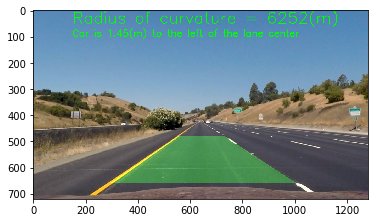

In [13]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(glob.glob('camera_cal/calibration*.jpg'), nx=9, ny=6)

def pipeline(image, mtx=mtx, dist=dist):
    
    
    print('pipeline - image shape ', image.shape)
    
    #plt.imshow(image)
    
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    warped_image, M, Minv = warp_image(undistorted_image)
    
    grad_thresh_image, gradx, grady, mag_binary, dir_binary, saturation_binary, hue_binary = apply_gradient_and_thresholds(warped_image, kernel_size = 9)
    
    

    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, ploty, left_curverad, right_curverad = sliding_window_search(grad_thresh_image)
    #visualize_sliding_window_search(grad_thresh_image, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img)

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #grad_thresh_image, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, left_curverad, right_curverad = find_lanes_without_sliding_window_search(grad_thresh_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #visualize_lanes(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds)

    #print('left_fit.shape ', left_fit.shape, ', ploty.shape ', ploty.shape, ', left_fitx.shape ', left_fitx.shape)
    
    lane_highlighted_image = highlight_lane(grad_thresh_image, left_fitx, right_fitx, ploty, Minv, undistorted_image, undistorted_image.shape)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_of_curvature_info = "Radius of curvature = " + str(int(left_curverad)) + "(m)"
    lane_center_info = get_lane_center_info(left_fitx, right_fitx, lane_highlighted_image)
    
    lane_highlighted_image = cv2.putText(lane_highlighted_image, radius_of_curvature_info,(150, 50), font, 2.0, (0, 255, 0), 2, cv2.LINE_AA)
    lane_highlighted_image = cv2.putText(lane_highlighted_image, lane_center_info,(150, 100), font, 1.2, (0, 255, 0), 2, cv2.LINE_AA)

    plt.imshow(lane_highlighted_image)
    #plt.imshow(image)
    
    return lane_highlighted_image

    
image_file_name = './test_images/straight_lines1.jpg'
#image_file_name = './test_images/test3.jpg'    
image = pipeline(mpimg.imread(image_file_name))    

pipeline - image shape  (720, 1280, 3)
histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1717.13896022996 m 975.4337882759455 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

pipeline - image shape  (720, 1280, 3)
histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1085
binary_warped.shape  (720, 1280)


  0%|          | 1/1261 [00:00<05:49,  3.60it/s]

window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1717.13896022996 m 975.4337882759455 m
pipeline - image shape  (720, 1280, 3)


  0%|          | 2/1261 [00:00<05:37,  3.73it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1645.8602616803917 m 1096.0124309836954 m
pipeline - image shape  (720, 1280, 3)


  0%|          | 3/1261 [00:00<05:26,  3.86it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1252.8730014551181 m 1525.4025857513893 m
pipeline - image shape  (720, 1280, 3)


  0%|          | 4/1261 [00:01<05:18,  3.94it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1248.0525902786326 m 1745.2845222330104 m
pipeline - image shape  (720, 1280, 3)


  0%|          | 5/1261 [00:01<05:16,  3.97it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  181 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1178.658156192474 m 2210.10989150111 m
pipeline - image shape  (720, 1280, 3)


  0%|          | 6/1261 [00:01<05:22,  3.89it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1240.1315745972151 m 2850.6519356205135 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 7/1261 [00:01<05:18,  3.94it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1274.7548087927935 m 3151.522100410304 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 8/1261 [00:02<05:15,  3.97it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  189 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1261.6384436978574 m 89682.43440557229 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 9/1261 [00:02<05:16,  3.96it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1337.8587166345274 m 1447.5142962546033 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 10/1261 [00:02<05:14,  3.98it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1576.4615731010745 m 1338.6694128889173 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 11/1261 [00:02<05:13,  3.99it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1479.507183571119 m 1847.4950709640848 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 12/1261 [00:02<05:10,  4.02it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1659.1632680726507 m 837.1748967981738 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 13/1261 [00:03<05:09,  4.03it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1576.2698820836156 m 934.4099626689741 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 14/1261 [00:03<05:08,  4.04it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1550.1644420441182 m 720.5498508675527 m
pipeline - image shape  (720, 1280, 3)


  1%|          | 15/1261 [00:03<05:07,  4.05it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1074.3505399891035 m 1203.3403856984353 m
pipeline - image shape  (720, 1280, 3)


  1%|▏         | 16/1261 [00:03<05:06,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1202.2533460663412 m 1649.0871737084333 m
pipeline - image shape  (720, 1280, 3)


  1%|▏         | 17/1261 [00:04<05:05,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1128.730780336765 m 152383.9314092639 m
pipeline - image shape  (720, 1280, 3)


  1%|▏         | 18/1261 [00:04<05:05,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1056.2529607058646 m 7870.411399335557 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 19/1261 [00:04<05:05,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1119
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1174.9121820588211 m 4576.982857047572 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 20/1261 [00:04<05:05,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1375.0823801580466 m 1967.5681652942212 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 21/1261 [00:05<05:04,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1680.8089192384675 m 2282.8216205306276 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 22/1261 [00:05<05:04,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2333.3832944406636 m 8132.508544973993 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 23/1261 [00:05<05:04,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1037
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5505.238090165469 m 3430.0479129452233 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 24/1261 [00:05<05:04,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5083.165285496963 m 2659.18938288956 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 25/1261 [00:06<05:04,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6481.619606561584 m 1157.6825222180314 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 26/1261 [00:06<05:04,  4.05it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5480.42369857307 m 1500.3777339191267 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 27/1261 [00:06<05:04,  4.05it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4829.698574682225 m 764.924404746431 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 28/1261 [00:06<05:03,  4.06it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2959.954123986164 m 980.8390196674779 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 29/1261 [00:07<05:02,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2339.8859800343375 m 1467.6331626356664 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 30/1261 [00:07<05:02,  4.07it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3280.5786717144983 m 1489.3179874333914 m
pipeline - image shape  (720, 1280, 3)


  2%|▏         | 31/1261 [00:07<05:01,  4.08it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1551.5274218546383 m 2246.7071949709616 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 32/1261 [00:07<05:00,  4.09it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1395.9506309821147 m 1733.8440215605137 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 33/1261 [00:08<04:59,  4.10it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1337.5003716039603 m 1536.931380707994 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 34/1261 [00:08<04:58,  4.11it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1296.8067630807755 m 1446.3528747425034 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 35/1261 [00:08<04:57,  4.12it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1450.2911080473175 m 1309.2253630825358 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 36/1261 [00:08<04:56,  4.12it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1363.9892502683251 m 1316.2322641550568 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 37/1261 [00:08<04:56,  4.13it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1447.8737582818273 m 1753.375250229513 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 38/1261 [00:09<04:55,  4.14it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1415.5681659342476 m 423.8182523159438 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 39/1261 [00:09<04:54,  4.14it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1454.7683344406325 m 597.3667995612592 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 40/1261 [00:09<04:54,  4.15it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1344.8254725500503 m 851.0748067685417 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 41/1261 [00:09<04:53,  4.16it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1070.1273149047108 m 1115.541996636495 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 42/1261 [00:10<04:52,  4.16it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1141.1728435141936 m 1891.0028283466593 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 43/1261 [00:10<04:52,  4.17it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1111
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
959.6459616666422 m 2672.854731911393 m
pipeline - image shape  (720, 1280, 3)


  3%|▎         | 44/1261 [00:10<04:51,  4.17it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1006.8276948279089 m 2700.955298789915 m
pipeline - image shape  (720, 1280, 3)


  4%|▎         | 45/1261 [00:10<04:51,  4.17it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
935.4887313749388 m 1520.7447093960634 m
pipeline - image shape  (720, 1280, 3)


  4%|▎         | 46/1261 [00:11<04:50,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
861.0920244106486 m 807.3281304324029 m
pipeline - image shape  (720, 1280, 3)


  4%|▎         | 47/1261 [00:11<04:50,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
931.2233252559224 m 671.6255415979978 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 48/1261 [00:11<04:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
984.1019620024978 m 996.6047046593484 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 49/1261 [00:11<04:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1026.876283704076 m 1558.3482403907506 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 50/1261 [00:11<04:48,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1004.4235919941352 m 382.4113299967739 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 51/1261 [00:12<04:48,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1076.3107534182884 m 339.68012546893016 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 52/1261 [00:12<04:47,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1195.85836018754 m 465.0571884440585 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 53/1261 [00:12<04:47,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1084.4032599934465 m 731.6346690080526 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 54/1261 [00:12<04:47,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1068.9830305079279 m 1016.7189270871313 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 55/1261 [00:13<04:47,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1019.8891283463315 m 1662.0685764174616 m
pipeline - image shape  (720, 1280, 3)


  4%|▍         | 56/1261 [00:13<04:46,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1116
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1245.9926493793112 m 2190.5916696769164 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 57/1261 [00:13<04:46,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1316.5059524935089 m 2397.9358395047 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 58/1261 [00:13<04:46,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1343.4782716929356 m 575.6335300382809 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 59/1261 [00:14<04:46,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1461.554245251537 m 712.3613189829804 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 60/1261 [00:14<04:45,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2075.117578303611 m 1949.6630725429823 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 61/1261 [00:14<04:45,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1030
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3015.16260502553 m 1544.8360590988632 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 62/1261 [00:14<04:45,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3889.236725328395 m 1545.8639327046124 m
pipeline - image shape  (720, 1280, 3)


  5%|▍         | 63/1261 [00:14<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3744.590678804281 m 390.494491311957 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 64/1261 [00:15<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7304.121461496487 m 770.9688049895956 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 65/1261 [00:15<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6475.851801173035 m 912.566309404599 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 66/1261 [00:15<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2330.6137529714065 m 1117.101891491785 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 67/1261 [00:15<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2191.7968217758093 m 2028.4079501857295 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 68/1261 [00:16<04:44,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1706.085760235829 m 2692.9560088599433 m
pipeline - image shape  (720, 1280, 3)


  5%|▌         | 69/1261 [00:16<04:43,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1284.974031085503 m 3309.128129772761 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 70/1261 [00:16<04:43,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1351.6833916614712 m 1854.2156444384757 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 71/1261 [00:16<04:43,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1134.540375793837 m 888.6668007087195 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 72/1261 [00:17<04:42,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  994
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1093.8270892274409 m 1166.0504016426974 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 73/1261 [00:17<04:42,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1001
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1131.4708234219752 m 2444.9550502858874 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 74/1261 [00:17<04:41,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1168.497062352262 m 2785.693584856202 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 75/1261 [00:17<04:41,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1029
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1279.4665157185207 m 695.6045921816113 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 76/1261 [00:18<04:41,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1476.2116794030576 m 623.3415787116493 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 77/1261 [00:18<04:41,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1959.4826220062366 m 727.3810170218817 m
pipeline - image shape  (720, 1280, 3)


  6%|▌         | 78/1261 [00:18<04:41,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2486.3816930504395 m 1009.5600885140483 m
pipeline - image shape  (720, 1280, 3)


  6%|▋         | 79/1261 [00:18<04:40,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3090.6697313166082 m 1257.532857083917 m
pipeline - image shape  (720, 1280, 3)


  6%|▋         | 80/1261 [00:19<04:40,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5208.427285609754 m 1341.5851685119835 m
pipeline - image shape  (720, 1280, 3)


  6%|▋         | 81/1261 [00:19<04:40,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3912.7055272599446 m 2537.4126756292935 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 82/1261 [00:19<04:39,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3804.695285197038 m 1840.3315984214792 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 83/1261 [00:19<04:39,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3031.759409786338 m 1634.1736347227259 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 84/1261 [00:19<04:39,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3798.411367052809 m 1525.3672616671663 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 85/1261 [00:20<04:39,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4059.6050368461465 m 1565.968725008459 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 86/1261 [00:20<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1020
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3522.23222247354 m 1679.6502951947468 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 87/1261 [00:20<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1028
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2384.706609216963 m 2050.6396228921913 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 88/1261 [00:20<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3629.235948786341 m 949.384184338279 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 89/1261 [00:21<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9001.469632060882 m 825.6813370083876 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 90/1261 [00:21<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1041
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6803.123182729753 m 862.5852931561102 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 91/1261 [00:21<04:38,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3154.554075261609 m 1133.5979142477113 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 92/1261 [00:21<04:37,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2918.655088005278 m 1914.743977974625 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 93/1261 [00:22<04:37,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2293.6868846991147 m 780470.7744666106 m
pipeline - image shape  (720, 1280, 3)


  7%|▋         | 94/1261 [00:22<04:37,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1740.0161309441094 m 273491.13047415303 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 95/1261 [00:22<04:37,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1017
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2289.7108486024335 m 19564.09852457116 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 96/1261 [00:22<04:37,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2669.380866213788 m 5205.019114798782 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 97/1261 [00:23<04:37,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  991
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2232.5925048133768 m 8212.199074797167 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 98/1261 [00:23<04:36,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1002
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1685.0250195093968 m 5120.285750160661 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 99/1261 [00:23<04:36,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1014
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1668.5487999978002 m 5101.369673258659 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 100/1261 [00:23<04:36,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2249.0813722902253 m 1519.7281325957163 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 101/1261 [00:24<04:35,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1035
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2457.605343555786 m 1196.7046149649611 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 102/1261 [00:24<04:35,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2706.4753568984497 m 1253.5352643779477 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 103/1261 [00:24<04:35,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2306.5233336552287 m 1087.7611358854465 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 104/1261 [00:24<04:35,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2138.2374861687367 m 1075.1496235474224 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 105/1261 [00:24<04:34,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2547.168057026814 m 1628.250078281726 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 106/1261 [00:25<04:34,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2285.9543349246637 m 1833.1078103718496 m
pipeline - image shape  (720, 1280, 3)


  8%|▊         | 107/1261 [00:25<04:34,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2465.303248739524 m 1835.9979250857702 m
pipeline - image shape  (720, 1280, 3)


  9%|▊         | 108/1261 [00:25<04:33,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1848.187222173544 m 7503.350609500453 m
pipeline - image shape  (720, 1280, 3)


  9%|▊         | 109/1261 [00:25<04:33,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1851.4732929697004 m 5473.38824528527 m
pipeline - image shape  (720, 1280, 3)


  9%|▊         | 110/1261 [00:26<04:33,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1649.251986966254 m 4704.336010070442 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 111/1261 [00:26<04:33,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1532.7614473513452 m 7371.119028935731 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 112/1261 [00:26<04:32,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1637.3921101885712 m 3487.3915092451057 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 113/1261 [00:26<04:32,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2153.708740875116 m 2650.357468351533 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 114/1261 [00:27<04:32,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2438.8254607394747 m 1462.936110740313 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 115/1261 [00:27<04:31,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2280.2714357119607 m 972.0515683343058 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 116/1261 [00:27<04:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1429.5209229115094 m 1076.2523126145165 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 117/1261 [00:27<04:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1370.0429221762872 m 1256.955819038264 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 118/1261 [00:27<04:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1301.1323552430954 m 2010.8167357182 m
pipeline - image shape  (720, 1280, 3)


  9%|▉         | 119/1261 [00:28<04:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1211.5996207078854 m 2228.1903764727294 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 120/1261 [00:28<04:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1158.0425590590935 m 1942.265004487019 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 121/1261 [00:28<04:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1072.1485961716587 m 1413.2956394387595 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 122/1261 [00:28<04:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1208.7326686561576 m 1515.4461784264454 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 123/1261 [00:29<04:29,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1022
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1177.0676631578967 m 1269.7040255239172 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 124/1261 [00:29<04:29,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1208.1247997267853 m 1198.6449294387241 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 125/1261 [00:29<04:29,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1339.2684853139244 m 1425.1057454027375 m
pipeline - image shape  (720, 1280, 3)


 10%|▉         | 126/1261 [00:29<04:29,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1354.5396686465986 m 989.9329981002716 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 127/1261 [00:30<04:29,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1419.9252624355504 m 911.1131886629922 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 128/1261 [00:30<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1244.71840181897 m 1007.3663187715149 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 129/1261 [00:30<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1023.6520514216554 m 1126.917244347716 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 130/1261 [00:30<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
968.5138095289476 m 2119.731029177178 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 131/1261 [00:31<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
926.833023397545 m 1605.150464378678 m
pipeline - image shape  (720, 1280, 3)


 10%|█         | 132/1261 [00:31<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
898.9819062077668 m 626.0551335554824 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 133/1261 [00:31<04:28,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1057.4136703439538 m 2357.3673073244204 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 134/1261 [00:31<04:27,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1043.2747109372199 m 802.0849148545834 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 135/1261 [00:32<04:27,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1334.6521745496807 m 803.534679379127 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 136/1261 [00:32<04:27,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  179 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1632.538662445483 m 891.3977692741191 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 137/1261 [00:32<04:27,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1818.397072323086 m 858.7603193883762 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 138/1261 [00:32<04:26,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2302.8427426460657 m 643.7074726070701 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 139/1261 [00:33<04:26,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3706.325828213886 m 554.3488041150675 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 140/1261 [00:33<04:26,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4409.487053159655 m 528.4891341346313 m
pipeline - image shape  (720, 1280, 3)


 11%|█         | 141/1261 [00:33<04:25,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  171 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2990.241153905006 m 776.5703934182957 m
pipeline - image shape  (720, 1280, 3)


 11%|█▏        | 142/1261 [00:33<04:25,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2887.2391397090796 m 1160.468719798551 m
pipeline - image shape  (720, 1280, 3)


 11%|█▏        | 143/1261 [00:33<04:25,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2268.112919265273 m 1595.028105740382 m
pipeline - image shape  (720, 1280, 3)


 11%|█▏        | 144/1261 [00:34<04:24,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1682.672314728752 m 1495.0417086494235 m
pipeline - image shape  (720, 1280, 3)


 11%|█▏        | 145/1261 [00:34<04:24,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1437.316894182872 m 1420.6380911684403 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 146/1261 [00:34<04:24,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1363.37717000715 m 817.7534873730277 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 147/1261 [00:34<04:24,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1296.8625265909016 m 724.9091453795835 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 148/1261 [00:35<04:23,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1276.3052497095587 m 1130.8655153704956 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 149/1261 [00:35<04:23,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1550.9933021877675 m 1321.8594088085092 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 150/1261 [00:35<04:23,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1688.7967238408307 m 1880.866502022048 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 151/1261 [00:35<04:23,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1883.1106368296225 m 525.2953829267628 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 152/1261 [00:36<04:22,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3302.576827764539 m 650.9087712557055 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 153/1261 [00:36<04:22,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1525.3217499991451 m 1109.998102254897 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 154/1261 [00:36<04:22,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2039.444113196554 m 1219.85444254123 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 155/1261 [00:36<04:21,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2729.7146797570867 m 2034.2421327891777 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 156/1261 [00:36<04:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1108
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2655.98820162421 m 3273.8852207158175 m
pipeline - image shape  (720, 1280, 3)


 12%|█▏        | 157/1261 [00:37<04:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1112
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2351.7847709265566 m 3640.430128751254 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 158/1261 [00:37<04:20,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2064.3517434683467 m 2010.642689846328 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 159/1261 [00:37<04:20,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1619.6776672672465 m 1048.3415388393971 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 160/1261 [00:37<04:20,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1859.1065597596987 m 729.9569202816998 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 161/1261 [00:38<04:20,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1372.615376090957 m 793.3859411673117 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 162/1261 [00:38<04:20,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1048
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1398.5793869014453 m 867.2944948242456 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 163/1261 [00:38<04:19,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1595.407979224208 m 544.1420575083308 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 164/1261 [00:38<04:19,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1975.7906798047088 m 554.663978883502 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 165/1261 [00:39<04:19,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1609.129290992576 m 928.1845713891447 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 166/1261 [00:39<04:19,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1340.2955232888048 m 1989.7516309943371 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 167/1261 [00:39<04:18,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1429.6183445246197 m 4235.199363545521 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 168/1261 [00:39<04:18,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1465.734291022423 m 5614.062150386218 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 169/1261 [00:39<04:18,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1511.1090954211086 m 9409.081839457393 m
pipeline - image shape  (720, 1280, 3)


 13%|█▎        | 170/1261 [00:40<04:18,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1035
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1393.9167383306444 m 5160.55227166499 m
pipeline - image shape  (720, 1280, 3)


 14%|█▎        | 171/1261 [00:40<04:17,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1188.4734993442396 m 1713.5642792062743 m
pipeline - image shape  (720, 1280, 3)


 14%|█▎        | 172/1261 [00:40<04:17,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1387.947656153977 m 730.3908996432943 m
pipeline - image shape  (720, 1280, 3)


 14%|█▎        | 173/1261 [00:40<04:17,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1339.2369900268873 m 1023.4869664151814 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 174/1261 [00:41<04:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1485.9649616523893 m 1124.9695334251314 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 175/1261 [00:41<04:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1730.4369225058372 m 651.1493562439215 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 176/1261 [00:41<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1032
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2615.6838774954813 m 436.88736883761385 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 177/1261 [00:41<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2314.749617199786 m 480.7682251131505 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 178/1261 [00:42<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2992.422930931504 m 588.469444811001 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 179/1261 [00:42<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4387.896922562985 m 842.7197540123362 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 180/1261 [00:42<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
341185.07544314465 m 1306.391085273502 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 181/1261 [00:42<04:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5943.097723034688 m 1355.2487853953241 m
pipeline - image shape  (720, 1280, 3)


 14%|█▍        | 182/1261 [00:43<04:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7272.032582505201 m 1292.0166950767193 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 183/1261 [00:43<04:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2909.0105494335353 m 836.2557784874391 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 184/1261 [00:43<04:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2085.4235766097213 m 540.8670895626191 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 185/1261 [00:43<04:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1407.4118791379442 m 589.2367660935882 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 186/1261 [00:44<04:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1029
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1167.2404702754034 m 546.8706756611597 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 187/1261 [00:44<04:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1065.8220655342097 m 558.9679732887915 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 188/1261 [00:44<04:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1023.492326488882 m 380.14073287861 m
pipeline - image shape  (720, 1280, 3)


 15%|█▍        | 189/1261 [00:44<04:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
995.4515622067667 m 471.35135589323716 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 190/1261 [00:45<04:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
861.6294423838431 m 643.8798124331367 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 191/1261 [00:45<04:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
897.8910681687117 m 1511.2111034048376 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 192/1261 [00:45<04:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1087.5702146319431 m 1867.884443973922 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 193/1261 [00:45<04:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
999.5294111553521 m 1561.35324818423 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 194/1261 [00:45<04:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1085.3208795718704 m 1704.92076489825 m
pipeline - image shape  (720, 1280, 3)


 15%|█▌        | 195/1261 [00:46<04:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1096.522472100259 m 977.0411566385272 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 196/1261 [00:46<04:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1217.9509870043364 m 782.5970070398636 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 197/1261 [00:46<04:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1446.1312413872731 m 1036.4757279087814 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 198/1261 [00:46<04:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1357.785676786342 m 1007.259651822839 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 199/1261 [00:47<04:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1436.369300354498 m 1283.9888733787704 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 200/1261 [00:47<04:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1788.5037527541028 m 686.6328655013758 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 201/1261 [00:47<04:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1953.7772350200933 m 622.952606886071 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 202/1261 [00:47<04:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1710.2234727447146 m 741.2756221931879 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 203/1261 [00:48<04:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1588.903033836967 m 1267.5577628983503 m
pipeline - image shape  (720, 1280, 3)


 16%|█▌        | 204/1261 [00:48<04:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1591.4656565122843 m 1702.4946084141397 m
pipeline - image shape  (720, 1280, 3)


 16%|█▋        | 205/1261 [00:48<04:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1493.2403803693621 m 1663.1047345053712 m
pipeline - image shape  (720, 1280, 3)


 16%|█▋        | 206/1261 [00:48<04:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1664.9206096718808 m 1865.13098308187 m
pipeline - image shape  (720, 1280, 3)


 16%|█▋        | 207/1261 [00:49<04:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1036
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1811.972319955268 m 1642.3200124274417 m
pipeline - image shape  (720, 1280, 3)


 16%|█▋        | 208/1261 [00:49<04:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1849.2569959309433 m 426.51669853023196 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 209/1261 [00:49<04:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1946.5455727239816 m 620.6647729055912 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 210/1261 [00:49<04:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1872.9798373377437 m 621.8580187209208 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 211/1261 [00:50<04:08,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1915.3175768150393 m 605.1597753513156 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 212/1261 [00:50<04:08,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1878.8179711633281 m 447.12634115552635 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 213/1261 [00:50<04:08,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1987.6352930673152 m 358.82421507562105 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 214/1261 [00:50<04:08,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1330.0437320464005 m 561.0586495668036 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 215/1261 [00:50<04:07,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1132.6796388482608 m 1057.3150085304364 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 216/1261 [00:51<04:07,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1039.0003655887826 m 1244.1864529219758 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 217/1261 [00:51<04:07,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
994.9417541834067 m 1430.354362528028 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 218/1261 [00:51<04:07,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
943.4468159742296 m 1307.4907188827472 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 219/1261 [00:51<04:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1023.2868397661816 m 1500.7918045277868 m
pipeline - image shape  (720, 1280, 3)


 17%|█▋        | 220/1261 [00:52<04:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
977.4165260856018 m 592.2961014406064 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 221/1261 [00:52<04:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1108.6107640535274 m 563.2279704374142 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 222/1261 [00:52<04:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1006
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1324.2259842477529 m 721.2579271968596 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 223/1261 [00:52<04:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1026
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1491.9943409731063 m 859.628722435039 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 224/1261 [00:53<04:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1491.8909409664082 m 1144.7466680215032 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 225/1261 [00:53<04:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1030
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1684.972355217396 m 645.9432775906471 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 226/1261 [00:53<04:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1029
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1553.00699524991 m 734.8288326072375 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 227/1261 [00:53<04:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1645.3431212602572 m 1181.3125545182268 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 228/1261 [00:54<04:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1583.128732742912 m 2038.3993543222182 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 229/1261 [00:54<04:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1732.0903867466222 m 3993.576506142231 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 230/1261 [00:54<04:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2023.6961215680685 m 5118.01228568141 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 231/1261 [00:54<04:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2191.7351384126823 m 3269.5132734526564 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 232/1261 [00:54<04:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1010
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2438.5478434445763 m 1125.9811214861747 m
pipeline - image shape  (720, 1280, 3)


 18%|█▊        | 233/1261 [00:55<04:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2850.043780679702 m 722.7110237713507 m
pipeline - image shape  (720, 1280, 3)


 19%|█▊        | 234/1261 [00:55<04:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1002
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3717.635301379708 m 951.6750858082444 m
pipeline - image shape  (720, 1280, 3)


 19%|█▊        | 235/1261 [00:55<04:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1001
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4803.393878467805 m 1124.3269584713887 m
pipeline - image shape  (720, 1280, 3)


 19%|█▊        | 236/1261 [00:55<04:02,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1003
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3953.3923800088946 m 1297.3838199209654 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 237/1261 [00:56<04:02,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1010
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
89705.94005768017 m 501.97178454119285 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 238/1261 [00:56<04:02,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1011
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9949.174279275798 m 490.16339492292695 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 239/1261 [00:56<04:01,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1020
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4456.624734528095 m 682.15019291367 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 240/1261 [00:56<04:01,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5342.110890698556 m 865.7419745754717 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 241/1261 [00:57<04:01,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  102 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4038.561550778862 m 1380.633900183582 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 242/1261 [00:57<04:01,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  101 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5265.632113170129 m 1721.4535765553237 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 243/1261 [00:57<04:01,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  105 , rightx_base  995
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2879.3182828744566 m 1479.059399901178 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 244/1261 [00:57<04:00,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1000
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3345.8179475284333 m 1355.1984323498493 m
pipeline - image shape  (720, 1280, 3)


 19%|█▉        | 245/1261 [00:57<04:00,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1008
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2685.953077557607 m 719.1331281614936 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 246/1261 [00:58<04:00,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  972
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2258.220696934442 m 907.725770263518 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 247/1261 [00:58<03:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  985
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2914.482630473061 m 921.8828750702477 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 248/1261 [00:58<03:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  986
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2340.162316205884 m 736.8358565446235 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 249/1261 [00:58<03:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1003
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4134.4972338023235 m 354.1827279559276 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 250/1261 [00:59<03:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1001
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3597.6264410426547 m 375.5866686579474 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 251/1261 [00:59<03:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1018
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2911.5694064527215 m 404.4564167166628 m
pipeline - image shape  (720, 1280, 3)


 20%|█▉        | 252/1261 [00:59<03:58,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1028
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2322.4091032410893 m 618.3217656209007 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 253/1261 [00:59<03:58,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2021.8006578204418 m 951.474063794018 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 254/1261 [01:00<03:58,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1804.8433333663156 m 1372.6285759927425 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 255/1261 [01:00<03:58,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  984
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1896.8304232740495 m 1576.1733626884734 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 256/1261 [01:00<03:57,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1000
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1934.9516191435723 m 1057.1920857772704 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 257/1261 [01:00<03:57,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1001
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1707.9949263271772 m 536.2885147162491 m
pipeline - image shape  (720, 1280, 3)


 20%|██        | 258/1261 [01:01<03:57,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  102 , rightx_base  991
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1894.021584768764 m 614.9125269200645 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 259/1261 [01:01<03:57,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  997
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2183.809370497787 m 602.0628053315387 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 260/1261 [01:01<03:57,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  991
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2598.9898306468867 m 666.2994296669631 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 261/1261 [01:01<03:56,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1004
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3534.153187391611 m 337.8563370973467 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 262/1261 [01:02<03:56,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  114 , rightx_base  1016
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3272.4124465771033 m 481.66236219793035 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 263/1261 [01:02<03:56,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1028
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2377.735910551683 m 638.110317379503 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 264/1261 [01:02<03:56,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2572.1290622924284 m 1219.0779111978425 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 265/1261 [01:02<03:55,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2330.0196716154824 m 1214.6547051003 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 266/1261 [01:02<03:55,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2197.7242181549223 m 1675.2900031257761 m
pipeline - image shape  (720, 1280, 3)


 21%|██        | 267/1261 [01:03<03:55,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1626.2090990023519 m 1687.0246833240228 m
pipeline - image shape  (720, 1280, 3)


 21%|██▏       | 268/1261 [01:03<03:55,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1484.0888444937284 m 1464.9341670157282 m
pipeline - image shape  (720, 1280, 3)


 21%|██▏       | 269/1261 [01:03<03:54,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1029
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1645.3251047011722 m 684.5823836121987 m
pipeline - image shape  (720, 1280, 3)


 21%|██▏       | 270/1261 [01:03<03:54,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1018
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1668.0450243524824 m 577.0717956042004 m
pipeline - image shape  (720, 1280, 3)


 21%|██▏       | 271/1261 [01:04<03:54,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1005
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1643.8083635511923 m 680.4223951294516 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 272/1261 [01:04<03:54,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  114 , rightx_base  1009
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1980.5924365365545 m 732.3991782541287 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 273/1261 [01:04<03:53,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1023
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2386.7887890723173 m 374.9448805589925 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 274/1261 [01:04<03:53,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1022
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2557.6224495151364 m 469.19328291586515 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 275/1261 [01:05<03:53,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2085.578154545009 m 571.4172598054548 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 276/1261 [01:05<03:53,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1048
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1810.8240768622013 m 1034.3740814722412 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 277/1261 [01:05<03:53,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1809.1894132544207 m 1386.5892336241857 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 278/1261 [01:05<03:52,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1772.0456124211173 m 2467.980794219103 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 279/1261 [01:06<03:52,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1640.4566975477323 m 2413.790507737016 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 280/1261 [01:06<03:52,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2115.4792025882807 m 1069.735281502757 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 281/1261 [01:06<03:52,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1028
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1836.554175632279 m 861.5322520398364 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 282/1261 [01:06<03:51,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1001
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2127.4529585728806 m 803.2701052853319 m
pipeline - image shape  (720, 1280, 3)


 22%|██▏       | 283/1261 [01:06<03:51,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1013
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2357.4773948197035 m 734.7686289211892 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 284/1261 [01:07<03:51,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1027
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2615.7896180239936 m 874.6980901849422 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 285/1261 [01:07<03:51,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1031
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3623.801027625924 m 417.60369838551674 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 286/1261 [01:07<03:50,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4575.5396255027645 m 484.7227614600682 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 287/1261 [01:07<03:50,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3839.9009403463087 m 696.9470693316401 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 288/1261 [01:08<03:50,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3783.602764724313 m 911.279930702839 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 289/1261 [01:08<03:50,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3028.1236722449767 m 1839.7963554826918 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 290/1261 [01:08<03:49,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3988.8335374494222 m 2991.1631229905506 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 291/1261 [01:08<03:49,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2319.902905215383 m 3191.725567753223 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 292/1261 [01:09<03:49,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2337.50824609154 m 2788.79350387311 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 293/1261 [01:09<03:49,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2461.167395584898 m 1165.6437129997987 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 294/1261 [01:09<03:48,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2460.6316281933555 m 1260.6906375890999 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 295/1261 [01:09<03:48,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1029
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2260.8488596075454 m 1312.8280913477777 m
pipeline - image shape  (720, 1280, 3)


 23%|██▎       | 296/1261 [01:10<03:48,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1041
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3560.3970048816204 m 1785.8314277873162 m
pipeline - image shape  (720, 1280, 3)


 24%|██▎       | 297/1261 [01:10<03:48,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
31067.936143830037 m 644.3937197113446 m
pipeline - image shape  (720, 1280, 3)


 24%|██▎       | 298/1261 [01:10<03:48,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11106.29037548769 m 673.7600909020007 m
pipeline - image shape  (720, 1280, 3)


 24%|██▎       | 299/1261 [01:10<03:47,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9449.992405967252 m 722.121133242003 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 300/1261 [01:11<03:47,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7137.1434584620065 m 1207.7171073179577 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 301/1261 [01:11<03:47,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8229.744848820155 m 1646.5352416938165 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 302/1261 [01:11<03:46,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5311.080653563533 m 2752.480936850235 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 303/1261 [01:11<03:46,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4028.472889073176 m 3337.996372703116 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 304/1261 [01:11<03:46,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3261.586161640737 m 3628.1247734286217 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 305/1261 [01:12<03:46,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2691.9191234497926 m 1164.8482327502645 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 306/1261 [01:12<03:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2024.2782962678398 m 1119.5884663229695 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 307/1261 [01:12<03:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2465.091088082823 m 1031.4336909007252 m
pipeline - image shape  (720, 1280, 3)


 24%|██▍       | 308/1261 [01:12<03:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2601.6468074444983 m 1107.9915920446258 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 309/1261 [01:13<03:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3697.728538649316 m 495.96772261739187 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 310/1261 [01:13<03:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
96408.59304237028 m 499.00292658915424 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 311/1261 [01:13<03:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
49743.67626744126 m 758.5960545683757 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 312/1261 [01:13<03:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4388.654506034697 m 1339.7985464892815 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 313/1261 [01:14<03:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5019.246831517635 m 6929.760518508286 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 314/1261 [01:14<03:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3702.619949350162 m 12761.805052487016 m
pipeline - image shape  (720, 1280, 3)


 25%|██▍       | 315/1261 [01:14<03:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4647.129450898167 m 20749.207335367853 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 316/1261 [01:14<03:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8824.516358533107 m 3444.009320246602 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 317/1261 [01:14<03:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4851.013828523507 m 1685.6191583990465 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 318/1261 [01:15<03:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9873.280814843773 m 1038.5301868754007 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 319/1261 [01:15<03:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1041
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11343.41761261068 m 1004.0973963805164 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 320/1261 [01:15<03:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8883.246147874665 m 1461.0118958516778 m
pipeline - image shape  (720, 1280, 3)


 25%|██▌       | 321/1261 [01:15<03:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
23250.450746514165 m 560.6851410656534 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 322/1261 [01:16<03:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18541.364281843806 m 632.1334787308101 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 323/1261 [01:16<03:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15159.096590584817 m 868.153022784792 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 324/1261 [01:16<03:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
28806.52340781084 m 1807.7026534048114 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 325/1261 [01:16<03:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
30446.518109432807 m 5418.491615999521 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 326/1261 [01:17<03:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12912.992137525744 m 5099.997644752568 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 327/1261 [01:17<03:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13277.744808919535 m 7337.586551920195 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 328/1261 [01:17<03:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
29702.050240011184 m 2202.498388070525 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 329/1261 [01:17<03:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4330.029806722116 m 978.9783584339276 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 330/1261 [01:17<03:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4201.574194642274 m 1174.7630468482666 m
pipeline - image shape  (720, 1280, 3)


 26%|██▌       | 331/1261 [01:18<03:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5501.5158425912905 m 1144.8603968298764 m
pipeline - image shape  (720, 1280, 3)


 26%|██▋       | 332/1261 [01:18<03:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  179 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4369.486535638974 m 932.0706928830815 m
pipeline - image shape  (720, 1280, 3)


 26%|██▋       | 333/1261 [01:18<03:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1048
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3276.879003734447 m 453.95943507842054 m
pipeline - image shape  (720, 1280, 3)


 26%|██▋       | 334/1261 [01:18<03:38,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5163.282439089182 m 510.1680805700602 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 335/1261 [01:19<03:38,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5822.14927171242 m 737.514322927386 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 336/1261 [01:19<03:38,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
162246.09517499633 m 1597.4189744488688 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 337/1261 [01:19<03:38,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4428.985309270266 m 2852.522250311174 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 338/1261 [01:19<03:38,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8877.998539401986 m 3351.910602688751 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 339/1261 [01:20<03:37,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9467.82304932695 m 2899.5016675535094 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 340/1261 [01:20<03:37,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6343.306574925906 m 11843.167090712373 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 341/1261 [01:20<03:37,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9630.436191056968 m 1678.6189688382133 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 342/1261 [01:20<03:37,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8038.829263812867 m 4395.117879756853 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 343/1261 [01:21<03:36,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  187 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3764.320619729543 m 3626.140469877862 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 344/1261 [01:21<03:36,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4840.0224979211425 m 4202.920072444187 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 345/1261 [01:21<03:36,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
23306.219830465205 m 935.0101804613706 m
pipeline - image shape  (720, 1280, 3)


 27%|██▋       | 346/1261 [01:21<03:36,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18677.41119961604 m 755.3851640402984 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 347/1261 [01:21<03:35,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8023.7981413096495 m 1022.1895748728685 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 348/1261 [01:22<03:35,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3457.6961180627877 m 1413.1603077298932 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 349/1261 [01:22<03:35,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2755.8330602167493 m 2449.8342445303538 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 350/1261 [01:22<03:35,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2553.888502916073 m 2753.2487060925564 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 351/1261 [01:22<03:34,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4864.927988799628 m 5351.0496530375785 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 352/1261 [01:23<03:34,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5899.632193157405 m 2024.3229779974974 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 353/1261 [01:23<03:34,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5070.974174784134 m 2436.795582359716 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 354/1261 [01:23<03:34,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11627.401734823814 m 2170.757401958397 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 355/1261 [01:23<03:33,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13965.692981977776 m 4667.717145656515 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 356/1261 [01:24<03:33,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7755.795640771614 m 4796.27283440512 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 357/1261 [01:24<03:33,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4253.879989912684 m 1389.3406391459757 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 358/1261 [01:24<03:33,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5374.205477519987 m 992.6607445592674 m
pipeline - image shape  (720, 1280, 3)


 28%|██▊       | 359/1261 [01:24<03:32,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
27590.687403109197 m 1674.9112399345363 m
pipeline - image shape  (720, 1280, 3)


 29%|██▊       | 360/1261 [01:24<03:32,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8411.522717823244 m 3350.9230299357187 m
pipeline - image shape  (720, 1280, 3)


 29%|██▊       | 361/1261 [01:25<03:32,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4715.51733417308 m 6166.908205473792 m
pipeline - image shape  (720, 1280, 3)


 29%|██▊       | 362/1261 [01:25<03:32,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  188 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3216.9097401781014 m 27052.225820344647 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 363/1261 [01:25<03:32,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  187 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4206.640427970109 m 10066.940921555126 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 364/1261 [01:25<03:31,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  171 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3199.631099756087 m 9714.321655405347 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 365/1261 [01:26<03:31,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  171 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3341.419178421588 m 9765.426292522736 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 366/1261 [01:26<03:31,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4418.829867844114 m 6033.197325126867 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 367/1261 [01:26<03:31,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
21113.043457214262 m 6603.633600328794 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 368/1261 [01:26<03:30,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5833.507084742694 m 4499.881633638168 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 369/1261 [01:27<03:30,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2943.4776658469173 m 2432.7631142106356 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 370/1261 [01:27<03:30,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1633.8701372558337 m 2436.9252702240074 m
pipeline - image shape  (720, 1280, 3)


 29%|██▉       | 371/1261 [01:27<03:30,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1903.0955096942741 m 2843.97369561741 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 372/1261 [01:27<03:29,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2145.84033703582 m 4636.627001563192 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 373/1261 [01:28<03:29,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1587.8077529594857 m 94971.67069575201 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 374/1261 [01:28<03:29,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1469.3772534923007 m 20118.543730277717 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 375/1261 [01:28<03:29,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1607.8403666197848 m 959261.103750431 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 376/1261 [01:28<03:28,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1985.1199664373232 m 47924.098957189606 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 377/1261 [01:28<03:28,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2073.5703656647624 m 13242.132089928753 m
pipeline - image shape  (720, 1280, 3)


 30%|██▉       | 378/1261 [01:29<03:28,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2338.242292803644 m 13313.02890387434 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 379/1261 [01:29<03:28,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2640.5842560116453 m 7033.901120730988 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 380/1261 [01:29<03:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2865.400630812103 m 4752.006001155343 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 381/1261 [01:29<03:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2858.053949278431 m 1513.0511689734394 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 382/1261 [01:30<03:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
24068.25145234173 m 939.0159697358027 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 383/1261 [01:30<03:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4796.8837707918465 m 1021.3668351593534 m
pipeline - image shape  (720, 1280, 3)


 30%|███       | 384/1261 [01:30<03:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
40332.24047278632 m 1168.941775322373 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 385/1261 [01:30<03:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7858.953773483034 m 2234.3862029066318 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 386/1261 [01:31<03:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4801.508539427412 m 3759.627180824782 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 387/1261 [01:31<03:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3080.584227604876 m 3924.8491549604614 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 388/1261 [01:31<03:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5209.616952080434 m 13044.069296259488 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 389/1261 [01:31<03:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9395.797843714545 m 146839.31492081837 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 390/1261 [01:32<03:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11557.644483870241 m 3960.5480217148643 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 391/1261 [01:32<03:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
31960.6353290937 m 2541.2800670464494 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 392/1261 [01:32<03:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2216311.0381245967 m 11447.665610352384 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 393/1261 [01:32<03:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18199.282400928572 m 4456.784096262626 m
pipeline - image shape  (720, 1280, 3)


 31%|███       | 394/1261 [01:32<03:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8386.414020626078 m 3224.142816791671 m
pipeline - image shape  (720, 1280, 3)


 31%|███▏      | 395/1261 [01:33<03:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7265.269073908632 m 1931.1956063970824 m
pipeline - image shape  (720, 1280, 3)


 31%|███▏      | 396/1261 [01:33<03:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7715.672568714515 m 2645.398224894225 m
pipeline - image shape  (720, 1280, 3)


 31%|███▏      | 397/1261 [01:33<03:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8655.311888702705 m 3347.0245103490524 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 398/1261 [01:33<03:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6334.086784872872 m 30653.287624365305 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 399/1261 [01:34<03:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15194.004439453629 m 52273.824899489315 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 400/1261 [01:34<03:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
51918.78538943174 m 31766.95079357762 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 401/1261 [01:34<03:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10850.585029913795 m 4132.860846827123 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 402/1261 [01:34<03:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6356.705755353894 m 5702.19682244574 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 403/1261 [01:35<03:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3757.890128750624 m 197258.76827610223 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 404/1261 [01:35<03:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2850.8400940390825 m 17673.616259264396 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 405/1261 [01:35<03:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4050.869356704453 m 14348.563438370069 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 406/1261 [01:35<03:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5984.215008087795 m 6049.9238035529825 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 407/1261 [01:36<03:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15722.231817649046 m 10437.995585600653 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 408/1261 [01:36<03:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7333.151866486544 m 16652.36290762426 m
pipeline - image shape  (720, 1280, 3)


 32%|███▏      | 409/1261 [01:36<03:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16522.619906139447 m 39220.16097365214 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 410/1261 [01:36<03:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5741.319535489096 m 6896.352860401092 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 411/1261 [01:36<03:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4953.544111364327 m 5452.527672451922 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 412/1261 [01:37<03:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3230.1468122195683 m 4299.96958057507 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 413/1261 [01:37<03:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1037
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5403.13232867147 m 1297.5521277859616 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 414/1261 [01:37<03:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8208.822518817644 m 1415.9429414106137 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 415/1261 [01:37<03:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1017
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6779.266929794264 m 60769.39400925528 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 416/1261 [01:38<03:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  118 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12244.688007743915 m 8694.99841850706 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 417/1261 [01:38<03:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5769.794007111524 m 2565.87440947609 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 418/1261 [01:38<03:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
26169.053026379435 m 22355.052711672684 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 419/1261 [01:38<03:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
51250.57910124731 m 13441.787404425606 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 420/1261 [01:39<03:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
36975.283445845904 m 77417.14422151777 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 421/1261 [01:39<03:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16672.503989503628 m 11286.655471007642 m
pipeline - image shape  (720, 1280, 3)


 33%|███▎      | 422/1261 [01:39<03:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
43972.86271241437 m 12566.200925853242 m
pipeline - image shape  (720, 1280, 3)


 34%|███▎      | 423/1261 [01:39<03:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15751.504877802363 m 4699.088034030288 m
pipeline - image shape  (720, 1280, 3)


 34%|███▎      | 424/1261 [01:40<03:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6755.675828926522 m 3481.288052270321 m
pipeline - image shape  (720, 1280, 3)


 34%|███▎      | 425/1261 [01:40<03:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16689.723772236594 m 1483.5247375766392 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 426/1261 [01:40<03:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10395.963196678062 m 3549.228571604787 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 427/1261 [01:40<03:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1011
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
159470.41633366272 m 7137.544588424529 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 428/1261 [01:40<03:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1031
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8963.816797066378 m 13606.311050010796 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 429/1261 [01:41<03:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1035
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
20541.951678588022 m 4113.660602724462 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 430/1261 [01:41<03:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10141.234967169657 m 2116.722711665349 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 431/1261 [01:41<03:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  118 , rightx_base  1037
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7058.734306081717 m 1679.371346553127 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 432/1261 [01:41<03:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4898.193867911937 m 5035.826160415164 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 433/1261 [01:42<03:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  118 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
65086.028896190575 m 9182.88766366522 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 434/1261 [01:42<03:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
53508.95633848005 m 18236.856271924484 m
pipeline - image shape  (720, 1280, 3)


 34%|███▍      | 435/1261 [01:42<03:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7995.210248259178 m 10093.818178966554 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 436/1261 [01:42<03:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10215.043319132335 m 19108.721843829906 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 437/1261 [01:43<03:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4722.613525920262 m 3345.6021779957664 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 438/1261 [01:43<03:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18768.275267233563 m 11899.192531353436 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 439/1261 [01:43<03:13,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1021
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5725.407057177732 m 312760.4482876027 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 440/1261 [01:43<03:13,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
14387.803870979798 m 6831.062295469619 m
pipeline - image shape  (720, 1280, 3)


 35%|███▍      | 441/1261 [01:43<03:13,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1017
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12585.769812671633 m 2099.7334309350667 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 442/1261 [01:44<03:13,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
36884.62528775323 m 1060.4686051030444 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 443/1261 [01:44<03:12,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  105 , rightx_base  1033
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15181.690931293459 m 1205.64552829097 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 444/1261 [01:44<03:12,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
585971.3648303892 m 1793.2093963621046 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 445/1261 [01:44<03:12,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4232.840598765735 m 5272.673407587044 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 446/1261 [01:45<03:12,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  98 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2855.2734429205157 m 21174.88104273723 m
pipeline - image shape  (720, 1280, 3)


 35%|███▌      | 447/1261 [01:45<03:11,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  98 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2746.4062590378708 m 5740.031251581986 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 448/1261 [01:45<03:11,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  94 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2808.4469380302817 m 3389.585117834793 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 449/1261 [01:45<03:11,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  98 , rightx_base  1013
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3180.6335242171112 m 1003.7535275558462 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 450/1261 [01:46<03:11,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1015
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3418.655396825628 m 1158.0305262996342 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 451/1261 [01:46<03:10,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1018
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4442.591233830384 m 1060.2345021060482 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 452/1261 [01:46<03:10,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  118 , rightx_base  1023
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13571.883560044813 m 1421.3434051042525 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 453/1261 [01:46<03:10,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1019
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8542.29424068269 m 728.7837552768203 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 454/1261 [01:46<03:10,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3658.504601522254 m 934.6838718809175 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 455/1261 [01:47<03:09,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1035
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2651.1821354759304 m 1646.3513839210198 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 456/1261 [01:47<03:09,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3822.6654527046476 m 2940.3994362764456 m
pipeline - image shape  (720, 1280, 3)


 36%|███▌      | 457/1261 [01:47<03:09,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6217.0664457166695 m 4080.5107854497255 m
pipeline - image shape  (720, 1280, 3)


 36%|███▋      | 458/1261 [01:47<03:09,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3990.3231110339184 m 13406.257677808584 m
pipeline - image shape  (720, 1280, 3)


 36%|███▋      | 459/1261 [01:48<03:08,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4450.030318531627 m 7788.38718024325 m
pipeline - image shape  (720, 1280, 3)


 36%|███▋      | 460/1261 [01:48<03:08,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1017
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3840.852215759053 m 2623.7073374607835 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 461/1261 [01:48<03:08,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1019
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7565.48749121413 m 1263.795790551099 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 462/1261 [01:48<03:08,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1022
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8925.167608536614 m 1559.9093425335875 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 463/1261 [01:49<03:08,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1013
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18499.593883668793 m 1172.2704231110968 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 464/1261 [01:49<03:07,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1014
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
56635.32250349544 m 1011.6645151761878 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 465/1261 [01:49<03:07,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4772.644928935604 m 650.8525430904485 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 466/1261 [01:49<03:07,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
43587.99228777454 m 1005.6069575499868 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 467/1261 [01:50<03:07,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1035
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
19591.51605329974 m 2563.0096065122216 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 468/1261 [01:50<03:06,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7669.542457120651 m 7274.714463387041 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 469/1261 [01:50<03:06,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1048
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
17576.439627071843 m 24988.232798477606 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 470/1261 [01:50<03:06,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10730.49452535434 m 28713.719234417076 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 471/1261 [01:51<03:06,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5597.523310704218 m 21790.674622815826 m
pipeline - image shape  (720, 1280, 3)


 37%|███▋      | 472/1261 [01:51<03:05,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1019
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3708.8050686606243 m 75078.49522581241 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 473/1261 [01:51<03:05,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1025
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4921.254062270007 m 6284.881312536236 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 474/1261 [01:51<03:05,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1017
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4642.491643445484 m 5645.390238577325 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 475/1261 [01:51<03:05,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1024
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3041.02018350326 m 16608.578236377867 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 476/1261 [01:52<03:04,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1030
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3000.2901230758885 m 10898.680903899958 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 477/1261 [01:52<03:04,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1030
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8914.824110607955 m 2417.4301560157483 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 478/1261 [01:52<03:04,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1033
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
60675.52062527995 m 1179.4093576162236 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 479/1261 [01:52<03:04,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
14254.336990620659 m 5991.194374591388 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 480/1261 [01:53<03:04,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
19514.936476610532 m 11533.688040536219 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 481/1261 [01:53<03:03,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7901.358495542388 m 22992.67800617442 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 482/1261 [01:53<03:03,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6732.405741707392 m 6588.844147861831 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 483/1261 [01:53<03:03,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13555.444157388389 m 7582.935814798945 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 484/1261 [01:54<03:03,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1033
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11131.284221185419 m 59112.67118596494 m
pipeline - image shape  (720, 1280, 3)


 38%|███▊      | 485/1261 [01:54<03:02,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9392.358695170084 m 3840.5019181135954 m
pipeline - image shape  (720, 1280, 3)


 39%|███▊      | 486/1261 [01:54<03:02,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1041
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5229.334334403617 m 1391.151196678261 m
pipeline - image shape  (720, 1280, 3)


 39%|███▊      | 487/1261 [01:54<03:02,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5161.986086781429 m 3305.840157612189 m
pipeline - image shape  (720, 1280, 3)


 39%|███▊      | 488/1261 [01:55<03:02,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4938.293456766226 m 3788.6611154197326 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 489/1261 [01:55<03:01,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1036
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5586.077831106262 m 1484.0318130037979 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 490/1261 [01:55<03:01,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1041
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8296.735591552339 m 1254.1986652471257 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 491/1261 [01:55<03:01,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5551.173863081328 m 45463.89466592551 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 492/1261 [01:55<03:01,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7701.594197939994 m 67513.1459547338 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 493/1261 [01:56<03:00,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
21709.795007335844 m 47445.92924991149 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 494/1261 [01:56<03:00,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
19029.85478925643 m 4215.842528209503 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 495/1261 [01:56<03:00,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  105 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
62911.41980916066 m 471690.48068087024 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 496/1261 [01:56<03:00,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
21595.653751610644 m 8129.993995563349 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 497/1261 [01:57<03:00,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
194784.9072642239 m 1175.356968505795 m
pipeline - image shape  (720, 1280, 3)


 39%|███▉      | 498/1261 [01:57<02:59,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
36852.13408317222 m 6770.9987494371435 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 499/1261 [01:57<02:59,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
87930.22035659703 m 4580.967327221574 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 500/1261 [01:57<02:59,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9893.22973164566 m 3327.9159265474855 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 501/1261 [01:58<02:59,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12526.9379896386 m 1108.2983198910379 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 502/1261 [01:58<02:58,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9106.190591671007 m 985.7993228619102 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 503/1261 [01:58<02:58,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4103.023141751553 m 1025.6319176860807 m
pipeline - image shape  (720, 1280, 3)


 40%|███▉      | 504/1261 [01:58<02:58,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3912.5666915152947 m 1371.0528749877976 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 505/1261 [01:59<02:58,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7176.772953867529 m 2056.0374262862647 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 506/1261 [01:59<02:58,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10811.206406812813 m 5397.173979723455 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 507/1261 [01:59<02:57,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12790.21275654369 m 2679.2189488027393 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 508/1261 [01:59<02:57,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
27330.74500869339 m 4010.176507705519 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 509/1261 [02:00<02:57,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
94613.96031594981 m 2297.103866914945 m
pipeline - image shape  (720, 1280, 3)


 40%|████      | 510/1261 [02:00<02:57,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8764.110858990594 m 1509.2434214167165 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 511/1261 [02:00<02:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6898.115472988159 m 3109.101562025346 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 512/1261 [02:00<02:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7165.522490552976 m 2601.428735112439 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 513/1261 [02:00<02:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1037
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12186.721078909583 m 1706.874506286532 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 514/1261 [02:01<02:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6545.62417215147 m 1130.7308937903078 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 515/1261 [02:01<02:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
392248.8174743841 m 1485.4839009262255 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 516/1261 [02:01<02:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
14238.402659592946 m 3710.9598321397193 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 517/1261 [02:01<02:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
178565.75197199872 m 2580.67780888648 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 518/1261 [02:02<02:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16249.235654657454 m 2197.879749953447 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 519/1261 [02:02<02:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
89675.71358948747 m 2340.7286366832764 m
pipeline - image shape  (720, 1280, 3)


 41%|████      | 520/1261 [02:02<02:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
14031.195506819204 m 1638.9405177589194 m
pipeline - image shape  (720, 1280, 3)


 41%|████▏     | 521/1261 [02:02<02:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8740.797280849396 m 2198.1240645130206 m
pipeline - image shape  (720, 1280, 3)


 41%|████▏     | 522/1261 [02:03<02:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
30032.890944589355 m 1679.8117722397626 m
pipeline - image shape  (720, 1280, 3)


 41%|████▏     | 523/1261 [02:03<02:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2813.443897069235 m 13596.547806442912 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 524/1261 [02:03<02:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3214.3280108153726 m 2170.4731209491397 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 525/1261 [02:03<02:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
59086.42168782221 m 440.92886236196 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 526/1261 [02:04<02:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3508.257277614771 m 2356.07481185887 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 527/1261 [02:04<02:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2306.0266708474383 m 1192.806023323328 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 528/1261 [02:04<02:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  94 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5939.337407348618 m 2558.9137119990846 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 529/1261 [02:04<02:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  105 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3101.7769875963086 m 1863.7525415475382 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 530/1261 [02:04<02:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
34940.80936028275 m 4293.998336447432 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 531/1261 [02:05<02:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4227.612511673334 m 7645.262706757353 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 532/1261 [02:05<02:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2923.389643049602 m 84594.51696216353 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 533/1261 [02:05<02:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1034
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6822.8067388569825 m 2395.3070960599734 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 534/1261 [02:05<02:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1036
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11215.1611631828 m 2497.992829307505 m
pipeline - image shape  (720, 1280, 3)


 42%|████▏     | 535/1261 [02:06<02:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
56502.42496018453 m 2564.014094878931 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 536/1261 [02:06<02:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6331.864717536477 m 4697.704387323235 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 537/1261 [02:06<02:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3117.0702076136954 m 1331.3311049903084 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 538/1261 [02:06<02:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3857.6095134905286 m 3352.1184872144545 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 539/1261 [02:07<02:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12077.412176095495 m 5465.456561703145 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 540/1261 [02:07<02:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8047.690089051005 m 5211.5283323987 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 541/1261 [02:07<02:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6280.269640057632 m 11146.869564954668 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 542/1261 [02:07<02:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4084.8198204354444 m 4569.58327774069 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 543/1261 [02:08<02:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3340.8739556749506 m 2272.6134414961916 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 544/1261 [02:08<02:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3677.0732475543264 m 3945.3219093468824 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 545/1261 [02:08<02:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1028
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5780.751856969161 m 8336.008356308086 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 546/1261 [02:08<02:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3154.705550704327 m 11754.631367134049 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 547/1261 [02:09<02:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16431.172654828453 m 4090.115711117696 m
pipeline - image shape  (720, 1280, 3)


 43%|████▎     | 548/1261 [02:09<02:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10898.518219486617 m 1570.3336389072751 m
pipeline - image shape  (720, 1280, 3)


 44%|████▎     | 549/1261 [02:09<02:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5243.7466830503 m 4445.984473983178 m
pipeline - image shape  (720, 1280, 3)


 44%|████▎     | 550/1261 [02:09<02:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4069.6937885391044 m 15679.688924665992 m
pipeline - image shape  (720, 1280, 3)


 44%|████▎     | 551/1261 [02:09<02:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
63657.73106308793 m 1801.9521285189217 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 552/1261 [02:10<02:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
108083.23379581196 m 1579.4980285385373 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 553/1261 [02:10<02:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  918
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13426.463824120918 m 1767.577940671739 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 554/1261 [02:10<02:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  922
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5968.974651429412 m 229.79424561548026 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 555/1261 [02:10<02:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  927
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11999.771138923128 m 91343.40425008038 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 556/1261 [02:11<02:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
13395.000129581402 m 1244.5308167584906 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 557/1261 [02:11<02:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3983.1607782796427 m 1272.2017379503507 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 558/1261 [02:11<02:45,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
59419.68108327801 m 1029.168902458685 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 559/1261 [02:11<02:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  112 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
21210.803116044113 m 633.4750032773347 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 560/1261 [02:12<02:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  89 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
91957.93232120482 m 514.1631589567949 m
pipeline - image shape  (720, 1280, 3)


 44%|████▍     | 561/1261 [02:12<02:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10912.491408767106 m 1187.2590783554576 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 562/1261 [02:12<02:45,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  74 , rightx_base  1140
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5472.298496280227 m 1676.2399499737842 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 563/1261 [02:13<02:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  89 , rightx_base  1119
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2068.7131407251145 m 12155.793503830284 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 564/1261 [02:13<02:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  99 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1436.79791553798 m 6244.04610449978 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 565/1261 [02:13<02:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1850.4166561467036 m 752.3054667275136 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 566/1261 [02:13<02:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2919.0984235135943 m 2269.4316667445255 m
pipeline - image shape  (720, 1280, 3)


 45%|████▍     | 567/1261 [02:14<02:44,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
22486.234045376023 m 511.2450237955991 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 568/1261 [02:14<02:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
24664.781914859057 m 843.0061110931388 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 569/1261 [02:14<02:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7193.96129374059 m 894.5566233582977 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 570/1261 [02:14<02:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2921.8493469863947 m 9350.740881635713 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 571/1261 [02:15<02:43,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
20778.981661175352 m 7485.176611845119 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 572/1261 [02:15<02:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5564.305937472409 m 1915.0005753509765 m
pipeline - image shape  (720, 1280, 3)


 45%|████▌     | 573/1261 [02:15<02:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  113 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4455.489781951843 m 8885.80161065931 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 574/1261 [02:15<02:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3443.8110597524937 m 2262.9268186188065 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 575/1261 [02:16<02:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1130
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4274.273223869407 m 4942.24871542342 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 576/1261 [02:16<02:42,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1132
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
25600.839666813048 m 2102.906780588113 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 577/1261 [02:16<02:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1136
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4277.841442891971 m 1705.7420230650182 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 578/1261 [02:16<02:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6859.033415829695 m 2789.538172343375 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 579/1261 [02:17<02:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4325.821047178935 m 318.45795797017524 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 580/1261 [02:17<02:41,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1154
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6424.604379856797 m 2705.4439866498947 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 581/1261 [02:17<02:40,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2089.663753822375 m 213.1766829116692 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 582/1261 [02:17<02:40,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2174.8744355182653 m 482.1614391284705 m
pipeline - image shape  (720, 1280, 3)


 46%|████▌     | 583/1261 [02:17<02:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1955.303974440155 m 284.569038379003 m
pipeline - image shape  (720, 1280, 3)


 46%|████▋     | 584/1261 [02:18<02:40,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1173
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2404.9469648730947 m 1481.8119544859373 m
pipeline - image shape  (720, 1280, 3)


 46%|████▋     | 585/1261 [02:18<02:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
66393.33664999885 m 333.595235265936 m
pipeline - image shape  (720, 1280, 3)


 46%|████▋     | 586/1261 [02:18<02:39,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2753.266012032448 m 188.85021844730852 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 587/1261 [02:18<02:39,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  121 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9023.716654225347 m 295.4502374561438 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 588/1261 [02:19<02:39,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  125 , rightx_base  1185
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2502.7538629365904 m 474.9715420324949 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 589/1261 [02:19<02:39,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1197
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3740.0375020481447 m 1153.2082607678526 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 590/1261 [02:19<02:38,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1208
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2155.4339099562853 m 325.2892408563613 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 591/1261 [02:19<02:38,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2375.2853308749027 m 580.3733507218138 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 592/1261 [02:20<02:38,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  114 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2160.3763537973514 m 635.7889946719409 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 593/1261 [02:20<02:38,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  110 , rightx_base  1037
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2350.7134032980853 m 393.7053981366303 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 594/1261 [02:20<02:37,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1578.7432889485879 m 298.89347302590403 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 595/1261 [02:20<02:37,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4087.9977824325647 m 961.7751404705594 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 596/1261 [02:21<02:37,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
38728.21029100901 m 1289.2227612626548 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 597/1261 [02:21<02:37,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  100 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4051.2551243280122 m 848.61267700816 m
pipeline - image shape  (720, 1280, 3)


 47%|████▋     | 598/1261 [02:21<02:37,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  100 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1912.567469779668 m 462.83394578062183 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 599/1261 [02:21<02:36,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  93 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1946.9121555334852 m 3561.6791636372973 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 600/1261 [02:22<02:36,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  87 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1530.734164729568 m 9047.924264308771 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 601/1261 [02:22<02:36,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  81 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5331.448427968397 m 669.177740824713 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 602/1261 [02:22<02:36,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  84 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
14178.237466048678 m 478.38738488105434 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 603/1261 [02:22<02:35,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  79 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5710.147212211323 m 261.976836038531 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 604/1261 [02:23<02:35,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4046.6849751916548 m 632.102255834979 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 605/1261 [02:23<02:35,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5167.666853298105 m 2080.459085967303 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 606/1261 [02:23<02:35,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  88 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12207.6983427409 m 11883.508498020483 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 607/1261 [02:23<02:34,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  90 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1872.928742358716 m 702.2921371613522 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 608/1261 [02:23<02:34,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  83 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2610.2326693267605 m 694.9571840089284 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 609/1261 [02:24<02:34,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  80 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7340.484013908779 m 305.81310883424413 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 610/1261 [02:24<02:34,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  75 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7821.429660644003 m 650.7298389601843 m
pipeline - image shape  (720, 1280, 3)


 48%|████▊     | 611/1261 [02:24<02:33,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  71 , rightx_base  1130
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3910.1237955728816 m 1605.1625007160685 m
pipeline - image shape  (720, 1280, 3)


 49%|████▊     | 612/1261 [02:24<02:33,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  77 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2345.642366049161 m 1650.373074710036 m
pipeline - image shape  (720, 1280, 3)


 49%|████▊     | 613/1261 [02:25<02:33,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  74 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8293.260983249313 m 1487.2459041426189 m
pipeline - image shape  (720, 1280, 3)


 49%|████▊     | 614/1261 [02:25<02:33,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  73 , rightx_base  999
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1014.1595162495245 m 5134.656080311656 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 615/1261 [02:25<02:33,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  70 , rightx_base  1008
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
817.0612258499744 m 1001.5028541590674 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 616/1261 [02:25<02:32,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  71 , rightx_base  1009
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
787.9536249887193 m 5527.902229645232 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 617/1261 [02:26<02:32,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  70 , rightx_base  798
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
820.115108903411 m 6.095206692390696 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 618/1261 [02:26<02:32,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  71 , rightx_base  1013
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
753.6839239225495 m 3370.403064583481 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 619/1261 [02:26<02:32,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  73 , rightx_base  1015
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1187.766082747128 m 1269.1738090006338 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 620/1261 [02:26<02:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  77 , rightx_base  1022
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2150.364743065418 m 1458.9237868428027 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 621/1261 [02:27<02:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  75 , rightx_base  1020
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6074.613756504776 m 529.2421125475927 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 622/1261 [02:27<02:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  73 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5237.75456400179 m 754.1376292231195 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 623/1261 [02:27<02:31,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  77 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2452.2779304194073 m 922.7488783190756 m
pipeline - image shape  (720, 1280, 3)


 49%|████▉     | 624/1261 [02:27<02:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  80 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1282.066170413948 m 1352.4890268840616 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 625/1261 [02:27<02:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  95 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
702.5866632627395 m 7764.108691222703 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 626/1261 [02:28<02:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  101 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
625.847797327981 m 14651.350861295869 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 627/1261 [02:28<02:30,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
761.9933989517255 m 108978.35353593795 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 628/1261 [02:28<02:29,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1050
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
951.2511372786512 m 2736.2503025192777 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 629/1261 [02:28<02:29,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
974.5177385612225 m 1094.620059609968 m
pipeline - image shape  (720, 1280, 3)


 50%|████▉     | 630/1261 [02:29<02:29,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1201.9400156143536 m 1134.5012645150036 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 631/1261 [02:29<02:29,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  91 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1814.3798813924907 m 1207.146627525148 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 632/1261 [02:29<02:28,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  83 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2187.542219472217 m 31165.606838511696 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 633/1261 [02:29<02:28,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  81 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2395.059466783166 m 16764.899432368722 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 634/1261 [02:30<02:28,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  88 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1499.5182416053012 m 905.5053578867949 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 635/1261 [02:30<02:28,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  106 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1307.140553488058 m 2698.8674450344583 m
pipeline - image shape  (720, 1280, 3)


 50%|█████     | 636/1261 [02:30<02:27,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1220.8689509934186 m 2403.436171460499 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 637/1261 [02:30<02:27,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1177.8545315341044 m 2087.824915534116 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 638/1261 [02:30<02:27,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1055.5320085481433 m 2289.0699467314976 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 639/1261 [02:31<02:27,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1206.5638795440927 m 1977.8440031398986 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 640/1261 [02:31<02:26,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1771.2024702840156 m 2881.6628336117665 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 641/1261 [02:31<02:26,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1439.20581750405 m 738.0074571945015 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 642/1261 [02:31<02:26,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1111
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1628.1979077826502 m 730.8067657907388 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 643/1261 [02:32<02:26,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1722.134053320522 m 794.9636413712647 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 644/1261 [02:32<02:26,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1265.092240828185 m 978.9230231332676 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 645/1261 [02:32<02:25,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1738.782694776091 m 1017.3523737538169 m
pipeline - image shape  (720, 1280, 3)


 51%|█████     | 646/1261 [02:32<02:25,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1656.6714361354682 m 484.13539602719754 m
pipeline - image shape  (720, 1280, 3)


 51%|█████▏    | 647/1261 [02:33<02:25,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1736.1202141081108 m 872.7330777298339 m
pipeline - image shape  (720, 1280, 3)


 51%|█████▏    | 648/1261 [02:33<02:25,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1460.5405276575618 m 823.1489065173615 m
pipeline - image shape  (720, 1280, 3)


 51%|█████▏    | 649/1261 [02:33<02:24,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2004.6007206239292 m 1124.0610146946278 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 650/1261 [02:33<02:24,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1629.1000469814906 m 1875.834590212895 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 651/1261 [02:34<02:24,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1734.249829336701 m 3705.040598997711 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 652/1261 [02:34<02:24,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1868.7610916522542 m 5781.677363328226 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 653/1261 [02:34<02:23,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4391.954167947578 m 4337.714363869091 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 654/1261 [02:34<02:23,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3125.801527190754 m 540.4069793613158 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 655/1261 [02:34<02:23,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4386.384773242093 m 784.0863369043622 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 656/1261 [02:35<02:23,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3063.9467717796706 m 766.2750735248691 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 657/1261 [02:35<02:22,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2663.7895232402598 m 898.8632070564822 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 658/1261 [02:35<02:22,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2270.654334443587 m 534.9088385423141 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 659/1261 [02:35<02:22,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1882.6493414082474 m 770.903500347145 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 660/1261 [02:36<02:22,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1207.156359611787 m 906.7856638552722 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 661/1261 [02:36<02:22,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1259.473652620401 m 1107.7212838632322 m
pipeline - image shape  (720, 1280, 3)


 52%|█████▏    | 662/1261 [02:36<02:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1067.4679296976208 m 2172.805851851248 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 663/1261 [02:36<02:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
996.2817041826548 m 82786.21283815573 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 664/1261 [02:37<02:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1003.4571131039359 m 7426.570337071197 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 665/1261 [02:37<02:21,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1256.3012543169884 m 16490.917601426347 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 666/1261 [02:37<02:20,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1035.2420876232404 m 1254.605427451186 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 667/1261 [02:37<02:20,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1093.6295871521509 m 829.5517948847682 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 668/1261 [02:38<02:20,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1244.4168058737628 m 1366.7775461975555 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 669/1261 [02:38<02:20,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1185.4245923517433 m 1178.2650043043818 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 670/1261 [02:38<02:19,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1246.0748326789667 m 1070.275686966808 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 671/1261 [02:38<02:19,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
964.2379110238734 m 479.96938923620615 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 672/1261 [02:39<02:19,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1151.2079793573814 m 756.4746007899724 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 673/1261 [02:39<02:19,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1156.8592828441624 m 697.8471081800805 m
pipeline - image shape  (720, 1280, 3)


 53%|█████▎    | 674/1261 [02:39<02:18,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1348.596434316743 m 848.6760533304941 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▎    | 675/1261 [02:39<02:18,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1266.3398810461654 m 2692.237766476683 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▎    | 676/1261 [02:40<02:18,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1835.7137339450103 m 7119.86009518427 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▎    | 677/1261 [02:40<02:18,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1324.5273289127717 m 4441.140105857457 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 678/1261 [02:40<02:18,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2064.63320556637 m 1429.541221113254 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 679/1261 [02:40<02:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1972.8438439561971 m 602.7958509929651 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 680/1261 [02:40<02:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2246.4224558183273 m 1005.8291257977629 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 681/1261 [02:41<02:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2900.800209449603 m 1505.1201380858124 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 682/1261 [02:41<02:17,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2735.9427852698705 m 1439.7210073813922 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 683/1261 [02:41<02:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2196.6633897605493 m 510.01897291498057 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 684/1261 [02:41<02:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3477.9089607030223 m 791.5892067425742 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 685/1261 [02:42<02:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2581.3534366905624 m 822.6607340113171 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 686/1261 [02:42<02:16,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3053.5475835407856 m 1536.8371545430969 m
pipeline - image shape  (720, 1280, 3)


 54%|█████▍    | 687/1261 [02:42<02:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1086
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2184.2497982929503 m 2220.7356331769724 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 688/1261 [02:42<02:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2397.2862114806053 m 2184.1313934140458 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 689/1261 [02:43<02:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2513.4417772090865 m 3187.679249515379 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 690/1261 [02:43<02:15,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2300.990920456222 m 1575.7962730361687 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 691/1261 [02:43<02:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1794.539174832681 m 776.6697370768533 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 692/1261 [02:43<02:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2196.4426120961907 m 929.2443692644697 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▍    | 693/1261 [02:44<02:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2608.571440764878 m 1150.7274860013074 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 694/1261 [02:44<02:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3922.4709221867815 m 1329.078288162768 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 695/1261 [02:44<02:14,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3103.869303225912 m 998.3433738045156 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 696/1261 [02:44<02:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2346.789216588708 m 1712.5091576393104 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 697/1261 [02:45<02:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2951.4303429198685 m 4439.115145107299 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 698/1261 [02:45<02:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1379.4582995457736 m 4292.29178597259 m
pipeline - image shape  (720, 1280, 3)


 55%|█████▌    | 699/1261 [02:45<02:13,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1386.2169463620376 m 3164.406533661199 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 700/1261 [02:45<02:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
992.9667285700197 m 5737.483518405455 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 701/1261 [02:46<02:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1166.2251345109783 m 2939.516919089572 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 702/1261 [02:46<02:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  187 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
994.2886005577637 m 2254.4066048853865 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 703/1261 [02:46<02:12,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1119.8464733747162 m 1108.8002624633011 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 704/1261 [02:46<02:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1052
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1057.9705410320223 m 2117.2331547128138 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 705/1261 [02:46<02:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1361.505897121819 m 1208.6344754760485 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 706/1261 [02:47<02:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1712.276445634436 m 1938.1804299698904 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 707/1261 [02:47<02:11,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1952.5992964494963 m 2554.0435793707006 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 708/1261 [02:47<02:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2113.834131531814 m 1177.3303068520245 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▌    | 709/1261 [02:47<02:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2419.9055810487953 m 902.0004616787071 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▋    | 710/1261 [02:48<02:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1784.5195917639396 m 1166.5097464802047 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▋    | 711/1261 [02:48<02:10,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1752.3304359600975 m 1595.1547370767696 m
pipeline - image shape  (720, 1280, 3)


 56%|█████▋    | 712/1261 [02:48<02:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1261.510768466715 m 3276.7132970464922 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 713/1261 [02:48<02:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1130.0331408586874 m 3906.031461191756 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 714/1261 [02:49<02:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1562.733794300629 m 2637.3554266808155 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 715/1261 [02:49<02:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  161 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1370.6055130637294 m 1445.9647687401932 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 716/1261 [02:49<02:09,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1406.1503762303703 m 1077.2783773047647 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 717/1261 [02:49<02:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1846.9654238324085 m 1172.0277209929254 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 718/1261 [02:49<02:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1830.0872440430196 m 1375.437142310497 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 719/1261 [02:50<02:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2466.5160263273647 m 1605.1300159505129 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 720/1261 [02:50<02:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2287.605792235258 m 714.4547659990608 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 721/1261 [02:50<02:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1491.8156771935846 m 850.6236821636895 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 722/1261 [02:50<02:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1328.8283028917795 m 976.6206377925611 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 723/1261 [02:51<02:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1512.3681185182602 m 1305.7492618741874 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 724/1261 [02:51<02:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1406.8823966887653 m 1258.8371477277578 m
pipeline - image shape  (720, 1280, 3)


 57%|█████▋    | 725/1261 [02:51<02:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1653.0909448399127 m 2320.5962596836353 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 726/1261 [02:51<02:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2032.9377774322074 m 2015.7883263601414 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 727/1261 [02:52<02:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  189 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1677.4042934361296 m 1965.5507579439652 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 728/1261 [02:52<02:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  191 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1840.0956260815897 m 809.2649602574538 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 729/1261 [02:52<02:05,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  193 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1895.3487041902374 m 1188.3761048668055 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 730/1261 [02:52<02:05,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  191 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1637.446579674811 m 1563.2407982789068 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 731/1261 [02:52<02:05,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  196 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1449.0052206945402 m 1642.4927202165986 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 732/1261 [02:53<02:05,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1258.539156787746 m 900.4830763909837 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 733/1261 [02:53<02:04,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1269.0449984807983 m 1402.5277227924278 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 734/1261 [02:53<02:04,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  205 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1192.5714986348057 m 1799.932938479664 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 735/1261 [02:53<02:04,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1199.3683637831905 m 2300.7438375867887 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 736/1261 [02:54<02:04,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
868.7964177352621 m 6878.3919007198565 m
pipeline - image shape  (720, 1280, 3)


 58%|█████▊    | 737/1261 [02:54<02:03,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  205 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
852.3811173758068 m 8836.556752043387 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▊    | 738/1261 [02:54<02:03,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  209 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
807.0132506280326 m 2547.462156011421 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▊    | 739/1261 [02:54<02:03,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  209 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
917.9642322138171 m 2695.7407786791837 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▊    | 740/1261 [02:54<02:03,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  211 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1033.0715190581466 m 1434.036371134041 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 741/1261 [02:55<02:02,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  211 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1320.3661154316826 m 1277.9011863207263 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 742/1261 [02:55<02:02,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  214 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1172.27388389926 m 1459.7071566760737 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 743/1261 [02:55<02:02,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1092.625821969924 m 1284.640453892056 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 744/1261 [02:55<02:02,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
966.9540053540073 m 1304.5783873015534 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 745/1261 [02:56<02:01,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1011.6433264113563 m 1092.838185724455 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 746/1261 [02:56<02:01,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
995.6977846220555 m 1104.1399861300956 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 747/1261 [02:56<02:01,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1090.465914441603 m 1308.5177269212384 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 748/1261 [02:56<02:01,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1112
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1003.1862555897476 m 1319.8926897997967 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 749/1261 [02:57<02:00,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1119
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1093.2532494607538 m 1602.777822308816 m
pipeline - image shape  (720, 1280, 3)


 59%|█████▉    | 750/1261 [02:57<02:00,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  225 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1371.0920004903696 m 1430.374111544481 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 751/1261 [02:57<02:00,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  229 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1953.9664159037516 m 1040.9436685226394 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 752/1261 [02:57<02:00,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  229 , rightx_base  1141
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2020.3826894477652 m 518.3519179955605 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 753/1261 [02:57<02:00,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  232 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2763.3657285753097 m 879.7288692126416 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 754/1261 [02:58<01:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  237 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2751.529291931674 m 1021.281703379593 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 755/1261 [02:58<01:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  236 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1989.7650863081499 m 1011.6918208734544 m
pipeline - image shape  (720, 1280, 3)


 60%|█████▉    | 756/1261 [02:58<01:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  242 , rightx_base  1108
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1934.9253259456555 m 569.7792974996859 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 757/1261 [02:58<01:59,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  244 , rightx_base  1111
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1526.3703803390652 m 800.6808292605658 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 758/1261 [02:59<01:58,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1702.226626538746 m 831.3739522295231 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 759/1261 [02:59<01:58,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1376.310801420497 m 1387.1404704618708 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 760/1261 [02:59<01:58,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  242 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1401.4285202847027 m 1769.1243196005964 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 761/1261 [02:59<01:58,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1122
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1210.3100133337034 m 2965.8152848451164 m
pipeline - image shape  (720, 1280, 3)


 60%|██████    | 762/1261 [02:59<01:57,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  220 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2015.3493226317464 m 2640.8473279301293 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 763/1261 [03:00<01:57,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  243 , rightx_base  1149
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2682.9285890349533 m 1244.2588214672714 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 764/1261 [03:00<01:57,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1164
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2205.107531010853 m 533.2340602547289 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 765/1261 [03:00<01:57,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  244 , rightx_base  1164
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2696.487719473299 m 768.0851529687022 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 766/1261 [03:00<01:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1122
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1817.8039238638275 m 1085.2865918936006 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 767/1261 [03:01<01:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2160.2750851942214 m 2059.3424626327446 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 768/1261 [03:01<01:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1125
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1595.3508533761385 m 979.4661694646078 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 769/1261 [03:01<01:56,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  224 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1783.0918572268038 m 1637.862171140644 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 770/1261 [03:01<01:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  225 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1438.4049032960775 m 2195.4786954246183 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 771/1261 [03:01<01:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  225 , rightx_base  1132
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1328.551938362638 m 5998.2986274101095 m
pipeline - image shape  (720, 1280, 3)


 61%|██████    | 772/1261 [03:02<01:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  225 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1124.5234009915644 m 7439.403236941465 m
pipeline - image shape  (720, 1280, 3)


 61%|██████▏   | 773/1261 [03:02<01:55,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1141
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1057.4230187795185 m 16050.088789198477 m
pipeline - image shape  (720, 1280, 3)


 61%|██████▏   | 774/1261 [03:02<01:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  249 , rightx_base  1163
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
829.471782103708 m 3565.247853866738 m
pipeline - image shape  (720, 1280, 3)


 61%|██████▏   | 775/1261 [03:02<01:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1165
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
978.1457150913897 m 1871.109128639082 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 776/1261 [03:03<01:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1168
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1053.9345846392578 m 847.2892474345522 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 777/1261 [03:03<01:54,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1171
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1270.8760063314278 m 1122.8606916090503 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 778/1261 [03:03<01:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1211.7726655510871 m 1197.4031950667177 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 779/1261 [03:03<01:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  248 , rightx_base  1129
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1070.8475426929904 m 1296.0822402227059 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 780/1261 [03:04<01:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1130
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
968.0946497829192 m 776.4762060728638 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 781/1261 [03:04<01:53,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1148
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1057.3811308963457 m 1169.3563094758013 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 782/1261 [03:04<01:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1153
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1346.1542153813768 m 1059.6923415344727 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 783/1261 [03:04<01:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1154
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1814.262802244693 m 1353.9047851033602 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 784/1261 [03:04<01:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1168
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1234.1627133201919 m 2436.612488151091 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 785/1261 [03:05<01:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  216 , rightx_base  1164
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1414.7867380244347 m 3659.447668184818 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 786/1261 [03:05<01:52,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  215 , rightx_base  1150
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1962.473234502861 m 3828.256792553606 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 787/1261 [03:05<01:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  216 , rightx_base  1170
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1552.2315795897844 m 2138.897736911484 m
pipeline - image shape  (720, 1280, 3)


 62%|██████▏   | 788/1261 [03:05<01:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1380.5246831903014 m 708.2180105933561 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 789/1261 [03:06<01:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1129
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2287.0058741911103 m 1863.8381965280262 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 790/1261 [03:06<01:51,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1134
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2369.3744190779335 m 1491.1318926127276 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 791/1261 [03:06<01:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1144
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2840.403100447712 m 1754.9264490859307 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 792/1261 [03:06<01:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2142.863768042193 m 865.791967466 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 793/1261 [03:06<01:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1936.7691762592046 m 1493.0110689566875 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 794/1261 [03:07<01:50,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1136
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1693.2325303004716 m 1253.195439441619 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 795/1261 [03:07<01:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  224 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1371.884385406772 m 1291.417625673475 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 796/1261 [03:07<01:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  226 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1111.0726580390356 m 1698.69617795338 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 797/1261 [03:07<01:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  224 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1436.3718625196002 m 1958.357908940589 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 798/1261 [03:08<01:49,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1150
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1741.9146975023434 m 1639.325526953008 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 799/1261 [03:08<01:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1153
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2334.0523710663306 m 995.2933841881304 m
pipeline - image shape  (720, 1280, 3)


 63%|██████▎   | 800/1261 [03:08<01:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  249 , rightx_base  1160
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2219.645173798221 m 612.0827695814353 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▎   | 801/1261 [03:08<01:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  220 , rightx_base  1125
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2662.932459158759 m 1303.0184775981927 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▎   | 802/1261 [03:09<01:48,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6986.853898742473 m 1693.1658310093324 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▎   | 803/1261 [03:09<01:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1132
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8151.811955991168 m 2858.909321511582 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 804/1261 [03:09<01:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  218 , rightx_base  1116
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8196.448711204881 m 1837.5444987666242 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 805/1261 [03:09<01:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  220 , rightx_base  1115
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7449.476054655483 m 2086.0791292103836 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 806/1261 [03:09<01:47,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  220 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4884.449093148653 m 5066.711393373573 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 807/1261 [03:10<01:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  219 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2618.6333825149163 m 20115.664685100277 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 808/1261 [03:10<01:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  246 , rightx_base  1119
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1796.482722208698 m 11055.95946957075 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 809/1261 [03:10<01:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1140
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1751.7568385153122 m 8329.78977549259 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 810/1261 [03:10<01:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  215 , rightx_base  1147
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2021.7449697691407 m 5802.075731543699 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 811/1261 [03:11<01:46,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  236 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1584.8560552088009 m 1548.5748757301035 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 812/1261 [03:11<01:45,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  230 , rightx_base  1128
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1738.5261695402662 m 2824.8190261385653 m
pipeline - image shape  (720, 1280, 3)


 64%|██████▍   | 813/1261 [03:11<01:45,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  227 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2608.2211765948045 m 37738.6835226714 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 814/1261 [03:11<01:45,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  224 , rightx_base  1122
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3241.6005660976202 m 7198.522353278038 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 815/1261 [03:11<01:45,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3357.170494611353 m 6379.839382930226 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 816/1261 [03:12<01:44,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  224 , rightx_base  1116
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1851.8526079556727 m 21714.27134119577 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 817/1261 [03:12<01:44,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1111
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1620.6344772752134 m 4765.380078737158 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 818/1261 [03:12<01:44,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  221 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1204.5119812846638 m 3093.413524342218 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▍   | 819/1261 [03:12<01:44,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  219 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1205.508342353142 m 3023.342626825201 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 820/1261 [03:13<01:43,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  215 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1098.5471260435927 m 24335.57303422915 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 821/1261 [03:13<01:43,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  211 , rightx_base  1116
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1195.3647152372598 m 2008.9818825718344 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 822/1261 [03:13<01:43,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  206 , rightx_base  1122
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1281.485594631487 m 1921.2577451513498 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 823/1261 [03:13<01:43,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1117
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1369.6595604855975 m 1090.173717029171 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 824/1261 [03:14<01:42,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1117
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1259.667893730351 m 970.9251893077698 m
pipeline - image shape  (720, 1280, 3)


 65%|██████▌   | 825/1261 [03:14<01:42,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1086
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1478.4218198210324 m 1876.34220792816 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 826/1261 [03:14<01:42,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1845.2539946833679 m 1771.1585440232752 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 827/1261 [03:14<01:42,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1853.1158448608235 m 1252.9571872079978 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 828/1261 [03:15<01:42,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  199 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2108.1709419920867 m 1925.731356994346 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 829/1261 [03:15<01:41,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2510.8650262956035 m 1638.1856116139568 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 830/1261 [03:15<01:41,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2257.796381464444 m 2802.427198196458 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 831/1261 [03:15<01:41,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2311.5482001303035 m 2159.873871089788 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 832/1261 [03:15<01:41,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  195 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1411.6852951890573 m 3297.6532090448563 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 833/1261 [03:16<01:40,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  195 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1408.353296983918 m 2280.28300103603 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 834/1261 [03:16<01:40,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  191 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1725.3349419487479 m 2066.329953491154 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▌   | 835/1261 [03:16<01:40,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1666.1340432455133 m 1632.6391728289898 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▋   | 836/1261 [03:16<01:40,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  181 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1937.7756449439403 m 1244.8753452445358 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▋   | 837/1261 [03:17<01:39,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2006.1670596609058 m 1107.540012777489 m
pipeline - image shape  (720, 1280, 3)


 66%|██████▋   | 838/1261 [03:17<01:39,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2129.8444624482745 m 1332.1253539996405 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 839/1261 [03:17<01:39,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2239.149543859103 m 3025.385551153097 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 840/1261 [03:17<01:39,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1916.4469855267973 m 2255.3026289477802 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 841/1261 [03:18<01:38,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2068.612065211271 m 2088.724365848409 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 842/1261 [03:18<01:38,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  163 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1919.4677776569565 m 2339.3486713590805 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 843/1261 [03:18<01:38,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1690.7181401335197 m 1854.3158453996255 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 844/1261 [03:18<01:38,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1247.8840388135782 m 2260.2254609916095 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 845/1261 [03:18<01:37,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1045.3057399986624 m 3214.808104211512 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 846/1261 [03:19<01:37,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1246.1486474972849 m 3864.6210664106584 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 847/1261 [03:19<01:37,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1465.5170357114393 m 1926.6301918870543 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 848/1261 [03:19<01:37,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1174.4698803450356 m 3399.476759661919 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 849/1261 [03:19<01:36,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1496.5696430517396 m 1627.5013390478482 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 850/1261 [03:20<01:36,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1528.018552792182 m 3323.259119205839 m
pipeline - image shape  (720, 1280, 3)


 67%|██████▋   | 851/1261 [03:20<01:36,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1361.3657004029474 m 28044.02230636887 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 852/1261 [03:20<01:36,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1088.185104449893 m 6413.4614644017765 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 853/1261 [03:20<01:36,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1056.3270484559343 m 5698.9266750642255 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 854/1261 [03:21<01:35,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1003.8639910290783 m 2219.0451599329954 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 855/1261 [03:21<01:35,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
937.4623995865492 m 3615.5009933645415 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 856/1261 [03:21<01:35,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1016.0565330624922 m 2897.356296667015 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 857/1261 [03:21<01:35,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1125.4545676734033 m 25127.170809217052 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 858/1261 [03:21<01:34,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1203.6585977875316 m 54916.29555372473 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 859/1261 [03:22<01:34,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  114 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1795.818025218038 m 6924.305237312715 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 860/1261 [03:22<01:34,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  114 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3716.3065446878263 m 3130.5043686663953 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 861/1261 [03:22<01:34,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5107.087800657757 m 2364.1621638221714 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 862/1261 [03:22<01:33,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4462.373868526945 m 5510.22889046599 m
pipeline - image shape  (720, 1280, 3)


 68%|██████▊   | 863/1261 [03:23<01:33,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4963.939293551169 m 1054.2532852184577 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▊   | 864/1261 [03:23<01:33,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6517.165671067313 m 1048.9871411354948 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▊   | 865/1261 [03:23<01:33,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1920.693260664755 m 16467.947060538445 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▊   | 866/1261 [03:23<01:32,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1566.335384063106 m 2449.6547128877173 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 867/1261 [03:24<01:32,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1134.1304479375822 m 1750.2663228378688 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 868/1261 [03:24<01:32,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1087.827503188594 m 2161.0075235051995 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 869/1261 [03:24<01:32,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1277.2881270491837 m 1904.5499356566722 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 870/1261 [03:24<01:32,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1175.9243954944075 m 2272.4061909409343 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 871/1261 [03:25<01:31,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1845.1846809341062 m 20289.1908698879 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 872/1261 [03:25<01:31,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1064
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3335.618142393424 m 11257.227785134311 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 873/1261 [03:25<01:31,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9709.04574115868 m 1717.354322007814 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 874/1261 [03:25<01:31,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3455.4362348095656 m 3753.695061403415 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 875/1261 [03:26<01:30,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3459.894304102783 m 1903.1714719646213 m
pipeline - image shape  (720, 1280, 3)


 69%|██████▉   | 876/1261 [03:26<01:30,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2104.6011611776858 m 7439.965903784394 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 877/1261 [03:26<01:30,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2045.0464476422515 m 6994.403448309672 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 878/1261 [03:26<01:30,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1405.5602946209292 m 2080.1430904125277 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 879/1261 [03:26<01:29,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1280.7143558651592 m 1990.160057000598 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 880/1261 [03:27<01:29,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1195.102130027787 m 2402.0045072553494 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 881/1261 [03:27<01:29,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1286.7597661058614 m 5735.852268842463 m
pipeline - image shape  (720, 1280, 3)


 70%|██████▉   | 882/1261 [03:27<01:29,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1304.2675772472487 m 65902.81953134759 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 883/1261 [03:27<01:29,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1974.8203138935496 m 29806.745495683732 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 884/1261 [03:28<01:28,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  142 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2765.977135337553 m 4857.502800464714 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 885/1261 [03:28<01:28,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1623.2030190969485 m 3259.592512369264 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 886/1261 [03:28<01:28,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1267.142449380063 m 9168.613258216468 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 887/1261 [03:28<01:28,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1174.8012888273583 m 3400.0757891241296 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 888/1261 [03:29<01:27,  4.25it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1147.2328559209266 m 3344.5984250263214 m
pipeline - image shape  (720, 1280, 3)


 70%|███████   | 889/1261 [03:29<01:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1282.247932540167 m 31959.81326949465 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 890/1261 [03:29<01:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1338.6628888041616 m 7443.223558552317 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 891/1261 [03:29<01:27,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1712.6998177242715 m 3975.4503666952287 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 892/1261 [03:30<01:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  143 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2089.8019812214557 m 5893.291214894353 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 893/1261 [03:30<01:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16689.251741927725 m 3721.2153321379787 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 894/1261 [03:30<01:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9653.5956912721 m 3333.0160203646587 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 895/1261 [03:30<01:26,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6737.8781306376 m 7736.141718293385 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 896/1261 [03:31<01:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4073.629371522567 m 1732.5545071874312 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 897/1261 [03:31<01:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3395.9038826077303 m 2113.8902923540268 m
pipeline - image shape  (720, 1280, 3)


 71%|███████   | 898/1261 [03:31<01:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3126.056305430509 m 2235.7977091370753 m
pipeline - image shape  (720, 1280, 3)


 71%|███████▏  | 899/1261 [03:31<01:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4668.3512023001995 m 1179.4339483039817 m
pipeline - image shape  (720, 1280, 3)


 71%|███████▏  | 900/1261 [03:32<01:25,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9577.937043872605 m 1960.684725870985 m
pipeline - image shape  (720, 1280, 3)


 71%|███████▏  | 901/1261 [03:32<01:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3272.368910184153 m 4598.52104098521 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 902/1261 [03:32<01:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1987.8125855062574 m 12357.172602235563 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 903/1261 [03:32<01:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1878.5649835584022 m 11443.705987540752 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 904/1261 [03:33<01:24,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1718.9430528044938 m 44867.67314976239 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 905/1261 [03:33<01:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1324.0645820466777 m 13172.450092270381 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 906/1261 [03:33<01:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1229.6505509061494 m 1835.5044155204762 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 907/1261 [03:33<01:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1830.1831574360865 m 6571.403040343711 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 908/1261 [03:33<01:23,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2624.537296432504 m 6559.178536922368 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 909/1261 [03:34<01:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3761.221732364892 m 4400.332000560704 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 910/1261 [03:34<01:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6711.699485629993 m 1075.3420989635706 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 911/1261 [03:34<01:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4430.127511933486 m 847.5919720629284 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 912/1261 [03:34<01:22,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4769.14020849224 m 12416.180570424278 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 913/1261 [03:35<01:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3112.150924143555 m 2164.6365367837448 m
pipeline - image shape  (720, 1280, 3)


 72%|███████▏  | 914/1261 [03:35<01:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2107.4926318993193 m 1900.424581560952 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 915/1261 [03:35<01:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1322.8477100747361 m 1785.6070636021652 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 916/1261 [03:35<01:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1180.0927763823067 m 1826.4994078050331 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 917/1261 [03:36<01:21,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1235.4750370915601 m 1315.4444262693125 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 918/1261 [03:36<01:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1260.0456208648025 m 6269.776932938594 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 919/1261 [03:36<01:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1319.166002873928 m 3598.099514876713 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 920/1261 [03:36<01:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1288.1959299056464 m 2424.2180546752256 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 921/1261 [03:36<01:20,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1319.4908303357843 m 2002.1873147400588 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 922/1261 [03:37<01:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1446.3496484308773 m 13530.580968030274 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 923/1261 [03:37<01:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1472.3359910307734 m 821777.2192161785 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 924/1261 [03:37<01:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1461.5314511572521 m 2822.4160329843953 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 925/1261 [03:38<01:19,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  123 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1217.018669392462 m 4121.88159357686 m
pipeline - image shape  (720, 1280, 3)


 73%|███████▎  | 926/1261 [03:38<01:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
789.4045436091616 m 2997.1702466832535 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▎  | 927/1261 [03:38<01:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
929.194849470239 m 4520.750005665648 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▎  | 928/1261 [03:38<01:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
898.6898898019103 m 3710.1832275064835 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▎  | 929/1261 [03:39<01:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1168.127967488564 m 3036.9803177268304 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 930/1261 [03:39<01:18,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1423.3964702524827 m 9837.323161399236 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 931/1261 [03:39<01:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2879.609966552948 m 1866.92899536723 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 932/1261 [03:39<01:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  118 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5619.64438836361 m 2820.1819789931947 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 933/1261 [03:40<01:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4898.631906471067 m 18519.496207781114 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 934/1261 [03:40<01:17,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2779.694444544681 m 3439.902176277193 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 935/1261 [03:40<01:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2438.255821144238 m 10452.649422944443 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 936/1261 [03:40<01:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2563.5538811238407 m 2861.209659292719 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 937/1261 [03:41<01:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2586.224050249595 m 2093.922187562298 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 938/1261 [03:41<01:16,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2290.882906569818 m 1713.4174020754926 m
pipeline - image shape  (720, 1280, 3)


 74%|███████▍  | 939/1261 [03:41<01:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4767.334204432011 m 3767.567153085368 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 940/1261 [03:41<01:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7948.513115515286 m 3216.0973733380056 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 941/1261 [03:42<01:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2410.7124437542093 m 1253.1935063237688 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 942/1261 [03:42<01:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  134 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2073.3899934945252 m 1012.347727366054 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 943/1261 [03:42<01:15,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2705.4900081909236 m 1557.9649702934296 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 944/1261 [03:42<01:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2706.575537542953 m 1794.8383978939007 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▍  | 945/1261 [03:43<01:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  132 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1712.7569641877094 m 2214.1567390201603 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 946/1261 [03:43<01:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1062
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2164.330643817713 m 1211.6074112387123 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 947/1261 [03:43<01:14,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1286.1031776774605 m 910.1699293152441 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 948/1261 [03:43<01:13,  4.24it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1085
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1227.741433172824 m 1811.4887298116057 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 949/1261 [03:44<01:13,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1172.6076858879287 m 2161.229393302586 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 950/1261 [03:44<01:13,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1030.5091552368597 m 3002.948139916747 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 951/1261 [03:44<01:13,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
867.9325002197502 m 2500.6153615091316 m
pipeline - image shape  (720, 1280, 3)


 75%|███████▌  | 952/1261 [03:44<01:12,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1193.7172348093898 m 2355.3026163847308 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 953/1261 [03:45<01:12,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  129 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1397.7278191411579 m 1227.9739155709663 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 954/1261 [03:45<01:12,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2366.8400309504873 m 1355.8862867948278 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 955/1261 [03:45<01:12,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2550.7210279666315 m 1613.9340522712473 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 956/1261 [03:45<01:12,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  131 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3356.711168368189 m 1428.7978640011218 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 957/1261 [03:46<01:11,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1846.4616339857334 m 1783.6799362805377 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 958/1261 [03:46<01:11,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2249.353351153815 m 2014.331436417996 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 959/1261 [03:46<01:11,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  133 , rightx_base  1108
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2288.7451999488485 m 3424.1196823376476 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 960/1261 [03:46<01:11,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1995.490133383694 m 3229.4313301450943 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▌  | 961/1261 [03:47<01:10,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1843.1922625967843 m 3457.799275347906 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▋  | 962/1261 [03:47<01:10,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1440.760491907706 m 65459.491450011155 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▋  | 963/1261 [03:47<01:10,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  147 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1674.474050278416 m 6206.531420042172 m
pipeline - image shape  (720, 1280, 3)


 76%|███████▋  | 964/1261 [03:47<01:10,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1128
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2048.8474012579586 m 2258.454222099879 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 965/1261 [03:48<01:09,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3327.5242992669396 m 1864.7180496321591 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 966/1261 [03:48<01:09,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1115
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2309.0726410405537 m 3126.6053902699573 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 967/1261 [03:48<01:09,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2177.419580960901 m 3551.8198611397424 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 968/1261 [03:48<01:09,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1806.491981127581 m 2204.207600226958 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 969/1261 [03:49<01:09,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2421.0551183341827 m 14107.572304571037 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 970/1261 [03:49<01:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2200.618818194518 m 4415.864243091019 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 971/1261 [03:49<01:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1242.7870595057818 m 29828.88605591685 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 972/1261 [03:49<01:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1660.4921147630557 m 12187.302312787786 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 973/1261 [03:50<01:08,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1108
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2448.0172315838213 m 7197.027545694398 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 974/1261 [03:50<01:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1134
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1856.141641948907 m 5322.828632642938 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 975/1261 [03:50<01:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1136
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6305.579283670808 m 2405.2107660201937 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 976/1261 [03:50<01:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2591.7693556112017 m 1233.9698963880542 m
pipeline - image shape  (720, 1280, 3)


 77%|███████▋  | 977/1261 [03:51<01:07,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2180.6345275809313 m 1283.4720066758823 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 978/1261 [03:51<01:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  198 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2239.050475647166 m 1387.0664112509357 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 979/1261 [03:51<01:06,  4.23it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
26157.55552169451 m 3231.073568024447 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 980/1261 [03:51<01:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  200 , rightx_base  1112
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5215.547590760366 m 1606.19212149417 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 981/1261 [03:52<01:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18839.048609254725 m 1849.5566647870057 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 982/1261 [03:52<01:06,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  200 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4875.957491434492 m 4125.157287559835 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 983/1261 [03:52<01:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1123
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7139.77671826317 m 2960.9430881981307 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 984/1261 [03:53<01:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  199 , rightx_base  1131
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2285.6007647087945 m 4149.770650484965 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 985/1261 [03:53<01:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1133
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1306.5240066767503 m 11936.567638204513 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 986/1261 [03:53<01:05,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  192 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2204.4004552457786 m 7068.60066368911 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 987/1261 [03:53<01:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  188 , rightx_base  1131
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2024.5356320218127 m 2561.8982174160765 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 988/1261 [03:54<01:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  193 , rightx_base  1115
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2932.2074380889335 m 872.9001359737308 m
pipeline - image shape  (720, 1280, 3)


 78%|███████▊  | 989/1261 [03:54<01:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  187 , rightx_base  1136
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3232.0974906959177 m 744.7891513202749 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▊  | 990/1261 [03:54<01:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12363.274834407506 m 411.45113481876905 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▊  | 991/1261 [03:55<01:04,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8998.178605660933 m 2760.171730446605 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▊  | 992/1261 [03:55<01:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
53724.847814420136 m 5422.407577699948 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▊  | 993/1261 [03:55<01:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1086
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
127758.06211340606 m 1040.1020345115571 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 994/1261 [03:55<01:03,  4.22it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1663.118173592284 m 983.0399216268736 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 995/1261 [03:56<01:03,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1202.5793175457038 m 951.446619487018 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 996/1261 [03:56<01:02,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1093.2835426097072 m 2738.5346390131926 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 997/1261 [03:56<01:02,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
810.4488256288998 m 5294.077436104472 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 998/1261 [03:56<01:02,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  789
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
954.5178744253569 m 38.4374145177774 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 999/1261 [03:57<01:02,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  144 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1079.628798898462 m 965.3473271814779 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 1000/1261 [03:57<01:01,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  139 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2658.420096010762 m 3612.462387450034 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 1001/1261 [03:57<01:01,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  135 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6465.601300263269 m 1489.5006757964063 m
pipeline - image shape  (720, 1280, 3)


 79%|███████▉  | 1002/1261 [03:57<01:01,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  109 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4494.831897202111 m 707.0191599694024 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1003/1261 [03:58<01:01,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  101 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3410.1406175813663 m 1626.0184280222027 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1004/1261 [03:58<01:01,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  94 , rightx_base  1156
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1883.1236201725626 m 11207.249237041768 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1005/1261 [03:58<01:00,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  90 , rightx_base  1110
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1449.7112638504957 m 49124.84127576707 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1006/1261 [03:59<01:00,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  108 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6306.743466832238 m 915.4713857761386 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1007/1261 [03:59<01:00,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1190.820373179327 m 960078.8658860493 m
pipeline - image shape  (720, 1280, 3)


 80%|███████▉  | 1008/1261 [03:59<01:00,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  115 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1247.763312978523 m 1390.59389612658 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1009/1261 [03:59<00:59,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  111 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
17803.004427815253 m 636.9851135280616 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1010/1261 [04:00<00:59,  4.21it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3856.567801765398 m 12574.046911942507 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1011/1261 [04:00<00:59,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1069
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3134.0372360377332 m 1016.2501024413608 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1012/1261 [04:00<00:59,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  91 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
12015.292147155968 m 984.0220009744495 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1013/1261 [04:00<00:58,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  86 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4335.221479740107 m 1974.6409699829476 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1014/1261 [04:01<00:58,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  84 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2918.372413413416 m 17466.800070001085 m
pipeline - image shape  (720, 1280, 3)


 80%|████████  | 1015/1261 [04:01<00:58,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4352.470175775807 m 1688.6457309093219 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1016/1261 [04:01<00:58,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  85 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2284.9356097284376 m 1062.8441196126205 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1017/1261 [04:02<00:58,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  88 , rightx_base  1051
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2760.370299982104 m 1146.1165576334279 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1018/1261 [04:02<00:57,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  85 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3999.19733840314 m 8104.40172985841 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1019/1261 [04:02<00:57,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  85 , rightx_base  1054
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4255.477778033899 m 4327.513674965689 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1020/1261 [04:02<00:57,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  80 , rightx_base  1059
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10216.44806342814 m 934.0292928914007 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1021/1261 [04:03<00:57,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  84 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2839.2483931794245 m 5673.7452474092315 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1022/1261 [04:03<00:56,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  80 , rightx_base  1061
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2176.235562920948 m 7511.995108046464 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1023/1261 [04:03<00:56,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  72 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
16962.84185050677 m 4616.0339416698025 m
pipeline - image shape  (720, 1280, 3)


 81%|████████  | 1024/1261 [04:03<00:56,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  68 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2855.2122450251895 m 3115.807006581313 m
pipeline - image shape  (720, 1280, 3)


 81%|████████▏ | 1025/1261 [04:04<00:56,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  65 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2387.907343282393 m 1329.0056315145691 m
pipeline - image shape  (720, 1280, 3)


 81%|████████▏ | 1026/1261 [04:04<00:55,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  69 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2713.7425637604847 m 3519.841571922931 m
pipeline - image shape  (720, 1280, 3)


 81%|████████▏ | 1027/1261 [04:04<00:55,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  73 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3411.828468181267 m 1279.0836731343477 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1028/1261 [04:04<00:55,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  71 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1577.294883600325 m 1817.0879608866658 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1029/1261 [04:05<00:55,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  73 , rightx_base  1057
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2567.860685313795 m 1539.8428773527605 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1030/1261 [04:05<00:55,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  70 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4091.213888539929 m 4679.935417914343 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1031/1261 [04:05<00:54,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  71 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1385.3441921205495 m 583.7291206084998 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1032/1261 [04:05<00:54,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  70 , rightx_base  1038
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1554.5347498181236 m 320.18962456865273 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1033/1261 [04:06<00:54,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  63 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1326.0589036537995 m 598.6136014432182 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1034/1261 [04:06<00:54,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  77 , rightx_base  1056
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1735.2341983114163 m 583.7530355016202 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1035/1261 [04:06<00:53,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  94 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
991.2874515559635 m 603.8928612919391 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1036/1261 [04:06<00:53,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  97 , rightx_base  1046
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3312.169459305996 m 373.10953800536913 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1037/1261 [04:07<00:53,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  98 , rightx_base  688
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2624.7260600566638 m 257.37270335414826 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1038/1261 [04:07<00:53,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1176
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
40693.15500389202 m 621.5315378744673 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1039/1261 [04:07<00:52,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1044
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
731.3476637278892 m 827.4961967112956 m
pipeline - image shape  (720, 1280, 3)


 82%|████████▏ | 1040/1261 [04:07<00:52,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  100 , rightx_base  1043
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
814.3059245376254 m 10455.918562326005 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1041/1261 [04:08<00:52,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  80 , rightx_base  1047
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1497.1412805411892 m 16178.346083349616 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1042/1261 [04:08<00:52,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  84 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1726.0991543623343 m 967.8516997046369 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1043/1261 [04:08<00:51,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  101 , rightx_base  1055
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1061.0720727592802 m 1335.7826442965907 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1044/1261 [04:08<00:51,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  107 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3571.353180247566 m 1067.2196840453737 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1045/1261 [04:09<00:51,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  101 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1339.4206474482976 m 1585.063875873967 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1046/1261 [04:09<00:51,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1060
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1420.0691798756789 m 2672.488716743736 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1047/1261 [04:09<00:51,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  103 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1007.7759768971257 m 2014.5242324431022 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1048/1261 [04:09<00:50,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  82 , rightx_base  1216
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1060.8343170577086 m 1058.0398561433897 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1049/1261 [04:10<00:50,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  79 , rightx_base  1063
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1012.7009276018019 m 13526.674065719511 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1050/1261 [04:10<00:50,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  72 , rightx_base  1067
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1260.6914142096937 m 664.6257604210908 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1051/1261 [04:10<00:50,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  77 , rightx_base  1039
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
882.9438505317801 m 8198.928892942804 m
pipeline - image shape  (720, 1280, 3)


 83%|████████▎ | 1052/1261 [04:10<00:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  75 , rightx_base  1042
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
976.5845344878619 m 7868.874276846865 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▎ | 1053/1261 [04:11<00:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  69 , rightx_base  1049
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
914.9477869014602 m 740.5600218293569 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▎ | 1054/1261 [04:11<00:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  83 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1243.1265484505236 m 3073.770644937678 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▎ | 1055/1261 [04:11<00:49,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  95 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1690.8590793887047 m 2447.352190107762 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▎ | 1056/1261 [04:11<00:48,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  94 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2478.08231465476 m 6299.890387318332 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1057/1261 [04:12<00:48,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  104 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8181.582866643378 m 4289.986054736506 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1058/1261 [04:12<00:48,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  116 , rightx_base  1053
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5550.136233211195 m 5283.092796975828 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1059/1261 [04:12<00:48,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
36578.99054652595 m 3450.8122365374506 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1060/1261 [04:13<00:47,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  138 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7213.951577028665 m 1556.1539257538793 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1061/1261 [04:13<00:47,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1040
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6779.749713235191 m 1909.357096630943 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1062/1261 [04:13<00:47,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1045
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3121.44562297425 m 4438.135356388753 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1063/1261 [04:13<00:47,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1058
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4391.7080589013085 m 2951.635456017312 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1064/1261 [04:14<00:47,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  149 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1510.9690273357635 m 1637.01216031488 m
pipeline - image shape  (720, 1280, 3)


 84%|████████▍ | 1065/1261 [04:14<00:46,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  122 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1839.1800789435486 m 3563.678233603041 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1066/1261 [04:14<00:46,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  117 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2137.7826924004476 m 4892.760121861589 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1067/1261 [04:14<00:46,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  119 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2702.9151772449127 m 2533.573871256036 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1068/1261 [04:15<00:46,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  120 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3125.699794156626 m 2095.4922990540385 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1069/1261 [04:15<00:45,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  124 , rightx_base  1066
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2446.0021880034 m 1219.1487495434842 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1070/1261 [04:15<00:45,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  127 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1733.1056513925594 m 3723.7048379828543 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▍ | 1071/1261 [04:15<00:45,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  126 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2082.034901729968 m 1120.6457018579144 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1072/1261 [04:16<00:45,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  130 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2473.6272462431493 m 2479.76921251022 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1073/1261 [04:16<00:44,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  128 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3639.678880246711 m 1763.8683178000633 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1074/1261 [04:16<00:44,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5059.845480083735 m 1341.3690616858232 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1075/1261 [04:16<00:44,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  136 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3867.059188040258 m 1117.58568001992 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1076/1261 [04:17<00:44,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  137 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1960.1432249331287 m 2691.8531394530064 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1077/1261 [04:17<00:43,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3372.084534766894 m 2125.4744655049303 m
pipeline - image shape  (720, 1280, 3)


 85%|████████▌ | 1078/1261 [04:17<00:43,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4027.720177159646 m 3191.0139822889473 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1079/1261 [04:17<00:43,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3036.425363354202 m 2191.017101827977 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1080/1261 [04:18<00:43,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2488.0164573827383 m 2046.608876193224 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1081/1261 [04:18<00:43,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2627.4819958573935 m 30851.43264552645 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1082/1261 [04:18<00:42,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2346.3224919041177 m 13394.625520634814 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1083/1261 [04:18<00:42,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2071.7689366607137 m 66086.57655275859 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1084/1261 [04:19<00:42,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1696.0346839960216 m 24633.574607256145 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1085/1261 [04:19<00:42,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1802.6041714595951 m 5564.679867266066 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1086/1261 [04:19<00:41,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2139.565239443464 m 2785.0556927092875 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▌ | 1087/1261 [04:19<00:41,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2200.275304799613 m 874.4555589868428 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▋ | 1088/1261 [04:19<00:41,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2272.2938179228017 m 1387.9931662839035 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▋ | 1089/1261 [04:20<00:41,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2102.7823714312563 m 11585.476089225678 m
pipeline - image shape  (720, 1280, 3)


 86%|████████▋ | 1090/1261 [04:20<00:40,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1886.8899979345642 m 1622.6411670620125 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1091/1261 [04:20<00:40,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1842.3523783670132 m 2342.3687528024425 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1092/1261 [04:20<00:40,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1098
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2035.5178122756402 m 2204.514232027266 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1093/1261 [04:21<00:40,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  154 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2840.9257993232404 m 25564.78505255324 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1094/1261 [04:21<00:39,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3051.276916215497 m 11364.404713972343 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1095/1261 [04:21<00:39,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1572.258366265128 m 1726.889446313672 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1096/1261 [04:21<00:39,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1903.5976073388117 m 6407.953588558284 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1097/1261 [04:22<00:39,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1949.9762766063675 m 2531.169188083391 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1098/1261 [04:22<00:38,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  159 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1749.0599111165573 m 1947.5926960268253 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1099/1261 [04:22<00:38,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1621.972516385043 m 2435.5567673906157 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1100/1261 [04:22<00:38,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  164 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2358.4057812436213 m 7124.920358092489 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1101/1261 [04:23<00:38,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2318.5083252893082 m 4427.758473416608 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1102/1261 [04:23<00:37,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1116
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8039.593937597901 m 2265.341094328212 m
pipeline - image shape  (720, 1280, 3)


 87%|████████▋ | 1103/1261 [04:23<00:37,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  165 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7964.825030564497 m 6628.522049377208 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1104/1261 [04:23<00:37,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  166 , rightx_base  1106
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
17641.35731446295 m 8399.394586118686 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1105/1261 [04:24<00:37,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1130
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
17591.527682316315 m 9355.711267396639 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1106/1261 [04:24<00:37,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7354.641007240399 m 67737.09186242997 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1107/1261 [04:24<00:36,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6405.527437463986 m 1511.3613987817137 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1108/1261 [04:24<00:36,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
17104.45051637525 m 3660.9320931849984 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1109/1261 [04:25<00:36,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1113
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6865.55164235153 m 6594.834712731293 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1110/1261 [04:25<00:36,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3999.321378464189 m 31555.603592380154 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1111/1261 [04:25<00:35,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  204 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2339.282127365036 m 1697.9943735854838 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1112/1261 [04:25<00:35,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2151.440045838567 m 13737.801037737705 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1113/1261 [04:25<00:35,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1117
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1563.9137155711335 m 2272.4986259546504 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1114/1261 [04:26<00:35,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1764.3624582088344 m 1501.3800308145958 m
pipeline - image shape  (720, 1280, 3)


 88%|████████▊ | 1115/1261 [04:26<00:34,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  195 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1313.662839078819 m 1242.2410909489824 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▊ | 1116/1261 [04:26<00:34,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1669.568326384095 m 1616.2933804118 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▊ | 1117/1261 [04:26<00:34,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1068
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2021.4804587421365 m 1801.2990561911085 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▊ | 1118/1261 [04:27<00:34,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  199 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2097.4675206746374 m 2021.5434155549917 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▊ | 1119/1261 [04:27<00:33,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3140.4215132073787 m 1286.1125620417163 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1120/1261 [04:27<00:33,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  194 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8455.495070271652 m 1352.9924789786298 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1121/1261 [04:27<00:33,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  193 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15815.23783955536 m 1222.3966934829755 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1122/1261 [04:28<00:33,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  190 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7548.136641001513 m 614.8767946568664 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1123/1261 [04:28<00:32,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1087
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8828.688403690707 m 766.0370282437533 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1124/1261 [04:28<00:32,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  188 , rightx_base  1083
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3264.8200165405665 m 1490.3628408933769 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1125/1261 [04:28<00:32,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6413.659987591869 m 1887.369245070984 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1126/1261 [04:29<00:32,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  186 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2966.183278277592 m 2627.2226881420725 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1127/1261 [04:29<00:32,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  188 , rightx_base  1092
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3495.33415098415 m 3222.649975355428 m
pipeline - image shape  (720, 1280, 3)


 89%|████████▉ | 1128/1261 [04:29<00:31,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1096
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3507.3767802108996 m 3446.5708739103598 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1129/1261 [04:29<00:31,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  190 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5134.609922088892 m 2225.8241954321325 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1130/1261 [04:30<00:31,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  190 , rightx_base  1099
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2855.67604524802 m 1882.313362391684 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1131/1261 [04:30<00:31,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  187 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2594.044953903625 m 2204.988890766331 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1132/1261 [04:30<00:30,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  191 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1955.5840915560582 m 2303.937387947173 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1133/1261 [04:30<00:30,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1736.3978176555768 m 2066.941888991959 m
pipeline - image shape  (720, 1280, 3)


 90%|████████▉ | 1134/1261 [04:30<00:30,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1351.934048846696 m 2996.181175256505 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1135/1261 [04:31<00:30,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  181 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1292.4001766773563 m 3007.183283803536 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1136/1261 [04:31<00:29,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1223.9330696600293 m 2952.980728883458 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1137/1261 [04:31<00:29,  4.18it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1080
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1198.2973560083663 m 2830.0387167411563 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1138/1261 [04:31<00:29,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1663.6541137651898 m 80177.43876603548 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1139/1261 [04:32<00:29,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2126.6597651037414 m 4925.7419630086115 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1140/1261 [04:32<00:28,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  153 , rightx_base  1072
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2613.8764948680237 m 1073.2273860029998 m
pipeline - image shape  (720, 1280, 3)


 90%|█████████ | 1141/1261 [04:32<00:28,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3400.5284698436085 m 1173.3828906167555 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1142/1261 [04:32<00:28,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5972.628794391909 m 1471.6780271918435 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1143/1261 [04:33<00:28,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4909.741121062804 m 1689.7280041296415 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1144/1261 [04:33<00:27,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4465.93214811822 m 1859.0079119826798 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1145/1261 [04:33<00:27,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1091
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7285.200983028206 m 2851.96453340868 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1146/1261 [04:33<00:27,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5714.075045781305 m 9156.690363998596 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1147/1261 [04:34<00:27,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  156 , rightx_base  1107
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3728.3820290686613 m 3251.9475648752164 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1148/1261 [04:34<00:26,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  158 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3386.8272351183796 m 2236.8196370230394 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1149/1261 [04:34<00:26,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  181 , rightx_base  1086
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2359.8516192024836 m 2676.3107840653824 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████ | 1150/1261 [04:34<00:26,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2737.2824867936015 m 3646.3080152257794 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████▏| 1151/1261 [04:34<00:26,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3319.6526935133597 m 5277.25506399553 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████▏| 1152/1261 [04:35<00:26,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  184 , rightx_base  1065
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2118.4906667810924 m 1730.2747157075833 m
pipeline - image shape  (720, 1280, 3)


 91%|█████████▏| 1153/1261 [04:35<00:25,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1081
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2147.8549092526773 m 1597.3400940770327 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1154/1261 [04:35<00:25,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2024.3761709172927 m 1198.9167964954725 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1155/1261 [04:35<00:25,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  150 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1628.580712456302 m 1771.0988174785743 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1156/1261 [04:36<00:25,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2227.2717747280963 m 2207.8272439985917 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1157/1261 [04:36<00:24,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1946.0757524754483 m 1658.7136556499686 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1158/1261 [04:36<00:24,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2737.5110119309225 m 4616.203641395532 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1159/1261 [04:36<00:24,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2549.758532293269 m 2510.776752234355 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1160/1261 [04:37<00:24,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  175 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1888.8892299386446 m 3934.873510543157 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1161/1261 [04:37<00:23,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  148 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2763.158857857385 m 3542.117399653156 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1162/1261 [04:37<00:23,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  172 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3761.0671817351135 m 1758.589215005952 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1163/1261 [04:37<00:23,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  146 , rightx_base  1070
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2326.840647989921 m 1409.17751251717 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1164/1261 [04:38<00:23,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1974.0577781990544 m 1790.1596815882851 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1165/1261 [04:38<00:22,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1077
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1870.9105588839616 m 1639.1495058964704 m
pipeline - image shape  (720, 1280, 3)


 92%|█████████▏| 1166/1261 [04:38<00:22,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1415.5617552173956 m 1653.5461110590024 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1167/1261 [04:38<00:22,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  169 , rightx_base  1094
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1152.208383214424 m 2034.6092372059668 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1168/1261 [04:38<00:22,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1095
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
968.4398305739007 m 1352.7507367961907 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1169/1261 [04:39<00:21,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1073
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
997.7222754911672 m 1639.8733330604502 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1170/1261 [04:39<00:21,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  168 , rightx_base  1078
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1025.369725830174 m 1293.4577802145827 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1171/1261 [04:39<00:21,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1076
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1139.8729446849406 m 1300.6109215698139 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1172/1261 [04:39<00:21,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  141 , rightx_base  1079
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1262.3935707162416 m 2031.8615571413322 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1173/1261 [04:40<00:21,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  140 , rightx_base  1086
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1596.0683946849663 m 1522.0500875862224 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1174/1261 [04:40<00:20,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1395.7344291415009 m 528.285043165939 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1175/1261 [04:40<00:20,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1071
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1723.7045996949525 m 568.329951286442 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1176/1261 [04:40<00:20,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  145 , rightx_base  1074
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2043.3169425851086 m 1007.4963411871084 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1177/1261 [04:41<00:20,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  151 , rightx_base  1075
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2694.5769789025285 m 1174.3587660277399 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1178/1261 [04:41<00:19,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  152 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3477.0492997253227 m 1885.1205693652453 m
pipeline - image shape  (720, 1280, 3)


 93%|█████████▎| 1179/1261 [04:41<00:19,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1082
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5427.441450241359 m 1912.7052957134133 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▎| 1180/1261 [04:41<00:19,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  155 , rightx_base  1084
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
7543.543575457617 m 16081.839443797462 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▎| 1181/1261 [04:41<00:19,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  157 , rightx_base  1090
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3139.1632964662376 m 3133.4546209620994 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▎| 1182/1261 [04:42<00:18,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  160 , rightx_base  1093
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4301.103168033733 m 3641.9291113085806 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1183/1261 [04:42<00:18,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  162 , rightx_base  1097
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9188.615754397322 m 48317.85977149073 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1184/1261 [04:42<00:18,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  167 , rightx_base  1101
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3624.37903784564 m 3330.602893240413 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1185/1261 [04:42<00:18,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1088
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
15484.098785634933 m 37253.790491234744 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1186/1261 [04:43<00:17,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  170 , rightx_base  1089
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6261.140665540301 m 1796.1775601765694 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1187/1261 [04:43<00:17,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8502.160416533745 m 4003.793634452408 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1188/1261 [04:43<00:17,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6285.643722733711 m 2668.90396660886 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1189/1261 [04:43<00:17,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  173 , rightx_base  1105
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5011.43445525011 m 2750.9296327963734 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1190/1261 [04:44<00:16,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10437.529415489033 m 3610.5548261288504 m
pipeline - image shape  (720, 1280, 3)


 94%|█████████▍| 1191/1261 [04:44<00:16,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  174 , rightx_base  1100
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6745.079940191496 m 78894.79180082945 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1192/1261 [04:44<00:16,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  177 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4029.6448390177206 m 1098.6885475301956 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1193/1261 [04:44<00:16,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  180 , rightx_base  1123
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1988.3264974548435 m 1134.9031794369776 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1194/1261 [04:44<00:15,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1736.8901461510623 m 1615.195786389581 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1195/1261 [04:45<00:15,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  182 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1725.0321910346327 m 1486.9661016609098 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1196/1261 [04:45<00:15,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  183 , rightx_base  1109
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1383.7521128072176 m 1269.994385256323 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▍| 1197/1261 [04:45<00:15,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  208 , rightx_base  1115
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1381.0713330009955 m 1420.0640567140945 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1198/1261 [04:45<00:15,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  207 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1424.841465385894 m 1428.9206882910983 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1199/1261 [04:46<00:14,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1856.0148691731802 m 1487.0127276044245 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1200/1261 [04:46<00:14,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  198 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2272.458144973504 m 1775.6960842389947 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1201/1261 [04:46<00:14,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  199 , rightx_base  1118
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1724.2231916885078 m 938.1027896366835 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1202/1261 [04:46<00:14,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  199 , rightx_base  1140
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1582.9540021654016 m 1033.2168826203956 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1203/1261 [04:47<00:13,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1123
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1646.4251224450093 m 2278.0548125229875 m
pipeline - image shape  (720, 1280, 3)


 95%|█████████▌| 1204/1261 [04:47<00:13,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  176 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2408.9658112963684 m 1510.1502730694326 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1205/1261 [04:47<00:13,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  178 , rightx_base  1126
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4541.323301111592 m 1383.9849601634055 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1206/1261 [04:47<00:13,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  185 , rightx_base  1142
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5567.773617837094 m 1546.7510623684213 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1207/1261 [04:48<00:12,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  189 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3409.36760969283 m 1242.2543408159927 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1208/1261 [04:48<00:12,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  191 , rightx_base  1149
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3521.126433368829 m 799.8077258575215 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1209/1261 [04:48<00:12,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2692.007502034125 m 854.920745200452 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1210/1261 [04:48<00:12,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  195 , rightx_base  1102
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2188.606792943107 m 1226.7597941024749 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1211/1261 [04:48<00:11,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  196 , rightx_base  1103
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1496.3888338917202 m 1257.5779641358554 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1212/1261 [04:49<00:11,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  198 , rightx_base  1104
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1241.4704819755334 m 666.6508959157671 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▌| 1213/1261 [04:49<00:11,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1261.8491572585078 m 1000.1695717952806 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▋| 1214/1261 [04:49<00:11,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1115
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1300.4940057204406 m 1770.8840237770646 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▋| 1215/1261 [04:49<00:10,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1114
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1335.4024515737694 m 1416.215735775432 m
pipeline - image shape  (720, 1280, 3)


 96%|█████████▋| 1216/1261 [04:50<00:10,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  222 , rightx_base  1119
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1147.9123717750558 m 1349.7822865587736 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1217/1261 [04:50<00:10,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  194 , rightx_base  1120
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2135.777137666547 m 1565.9330472718596 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1218/1261 [04:50<00:10,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  195 , rightx_base  1122
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2482.6309799703463 m 1475.154297606635 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1219/1261 [04:50<00:10,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  192 , rightx_base  1149
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1822.4715575956727 m 680.004763102666 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1220/1261 [04:51<00:09,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1111
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1947.5565691173679 m 705.6914643754172 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1221/1261 [04:51<00:09,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  197 , rightx_base  1142
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1772.7980496594591 m 976.8789190843358 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1222/1261 [04:51<00:09,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  201 , rightx_base  1127
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2106.3866639845132 m 1132.7950998467477 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1223/1261 [04:51<00:09,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  204 , rightx_base  1121
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2031.0938475896255 m 556.7679482418631 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1224/1261 [04:51<00:08,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  204 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1755.455402572956 m 543.791658526227 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1225/1261 [04:52<00:08,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  207 , rightx_base  1123
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2106.7480153101774 m 1397.423909222272 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1226/1261 [04:52<00:08,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  206 , rightx_base  1128
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1603.4861737471306 m 2211.092134459209 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1227/1261 [04:52<00:08,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1134
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2326.603318720469 m 1920.2625098833116 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1228/1261 [04:52<00:07,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4061.6730987195947 m 1675.604321777557 m
pipeline - image shape  (720, 1280, 3)


 97%|█████████▋| 1229/1261 [04:53<00:07,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  200 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5007.090988302241 m 2535.089243418056 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1230/1261 [04:53<00:07,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  230 , rightx_base  1163
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
31445.724331989204 m 882.1830711905279 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1231/1261 [04:53<00:07,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  203 , rightx_base  1158
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
21228.05700764675 m 621.4243402264552 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1232/1261 [04:53<00:06,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  202 , rightx_base  1144
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
11517.162104639867 m 891.7314987443082 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1233/1261 [04:54<00:06,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  207 , rightx_base  1124
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5848.97421076069 m 958.9588588554625 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1234/1261 [04:54<00:06,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  208 , rightx_base  1125
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3184.0753746486635 m 907.7524965234715 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1235/1261 [04:54<00:06,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  236 , rightx_base  1130
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2761.2529039697465 m 1279.573633212304 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1236/1261 [04:54<00:05,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  237 , rightx_base  1133
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2230.107807568181 m 7111.706538101611 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1237/1261 [04:55<00:05,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  237 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2077.02347161588 m 5676.418263896014 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1238/1261 [04:55<00:05,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  238 , rightx_base  1141
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
1989.712887386627 m 15743.164359839751 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1239/1261 [04:55<00:05,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  239 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2295.115771404901 m 12649.570277237974 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1240/1261 [04:55<00:05,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  237 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
8633.93768435549 m 7298.619405308216 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1241/1261 [04:55<00:04,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  239 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
18580.768971558293 m 2967.0255246136435 m
pipeline - image shape  (720, 1280, 3)


 98%|█████████▊| 1242/1261 [04:56<00:04,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  210 , rightx_base  1137
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6442.992121886146 m 2669.829340857684 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▊| 1243/1261 [04:56<00:04,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  209 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
4026.27845551721 m 1775.8236543721355 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▊| 1244/1261 [04:56<00:04,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  212 , rightx_base  1139
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
5531.329863467462 m 7604.747360008165 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▊| 1245/1261 [04:56<00:03,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  241 , rightx_base  1142
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
110389.23453784802 m 39122.9925087509 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1246/1261 [04:57<00:03,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  241 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
804300.9020359307 m 1327.1640080205416 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1247/1261 [04:57<00:03,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  246 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3641.2711570783217 m 2207.5508109819034 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1248/1261 [04:57<00:03,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  244 , rightx_base  1143
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2994.1428782089292 m 16681.050544320868 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1249/1261 [04:57<00:02,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1145
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2484.335876093721 m 25657.82104365636 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1250/1261 [04:58<00:02,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  245 , rightx_base  1146
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
2378.889268059083 m 3511.4289087734496 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1251/1261 [04:58<00:02,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  239 , rightx_base  1157
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6980.516678204541 m 3948.3835555553956 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1252/1261 [04:58<00:02,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  238 , rightx_base  1145
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
19128.602895737862 m 2367.5965556053097 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1253/1261 [04:58<00:01,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  236 , rightx_base  1142
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
30032.36131438929 m 1587.1226076621315 m
pipeline - image shape  (720, 1280, 3)


 99%|█████████▉| 1254/1261 [04:58<00:01,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  232 , rightx_base  1144
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9316.123795908048 m 1647.5372548970936 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1255/1261 [04:59<00:01,  4.19it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  233 , rightx_base  1146
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
10540.32893017168 m 5286.53658768931 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1256/1261 [04:59<00:01,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  229 , rightx_base  1128
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
6977.635564418512 m 10433.130326340572 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1257/1261 [04:59<00:00,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  227 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3351.8275236104205 m 1042.5249112280808 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1258/1261 [04:59<00:00,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  223 , rightx_base  1138
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3431.502963919164 m 1568.1116656022632 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1259/1261 [05:00<00:00,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  213 , rightx_base  1142
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
3759.4468405929156 m 8758.141677407208 m
pipeline - image shape  (720, 1280, 3)


100%|█████████▉| 1260/1261 [05:00<00:00,  4.20it/s]

histogram.shape  (1280,)
midpoint  640 , leftx_base  212 , rightx_base  1135
binary_warped.shape  (720, 1280)
window count is  0
window count is  1
window count is  2
window count is  3
window count is  4
window count is  5
window count is  6
window count is  7
window count is  8
ploty  (720,)
left_fitx  (720,)
right_fitx  (720,)
np.max(ploty)  719.0
9518.177569232808 m 104729.23095041084 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 1s, sys: 46.7 s, total: 6min 48s
Wall time: 5min


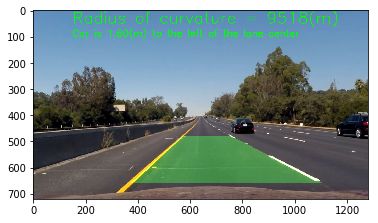

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = "project_video_output.mp4"
input_video = "project_video.mp4"
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(pipeline)

%time white_clip.write_videofile(output_video, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))